Imports

In [250]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                  import stats as ss
from boruta                 import BorutaPy
from matplotlib             import pyplot as plt
from IPython.display        import Image
from IPython.core.display   import HTML
from tabulate              import tabulate
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

Auxiliar functions

In [257]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):

    # Lists to store results
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        
        # Verbose Mode
        if verbose:
            print(f'Kfold Number: {k}')
            
        # start and end for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation Dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat))

        # store performance for each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])


In [258]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1) / (n - 1))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (k - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1))) 

In [259]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

In [260]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

In [261]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({
        'Model Name' : model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])

In [268]:
def jupyter_settings():
     %matplotlib inline
     %pylab inline
     plt.style.use( 'bmh' )
     plt.rcParams['figure.figsize'] = [25, 12]
     plt.rcParams['font.size'] = 24
     display( HTML( '<style>.container { width:100% !important; }</style>') )
     pd.options.display.max_columns = None
     pd.options.display.max_rows = None
     pd.set_option( 'display.expand_frame_repr', False )
     sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Loading Data

In [125]:
df_sales_raw = pd.read_csv(r'C:\Users\Leticia Furletti\Repos\DATA_SCIENCE\Comunidade_Ds\DS_em_producao\data\train.csv', low_memory=False)
df_store_raw = pd.read_csv(r'C:\Users\Leticia Furletti\Repos\DATA_SCIENCE\Comunidade_Ds\DS_em_producao\data\store.csv', low_memory=False)

#unindo os dois dataframes em um só com a função merge (a união sera por meio da coluna Store, que existe nos dois dfs)
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

#para ver como ficou uso df_raw.sample()
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
582542,183,6,2014-01-25,2364,306,1,0,0,0,a,a,9670.0,NaN,NaN,0,NaN,NaN,NaN


1-Data description

*Id - an Id that represents a (Store, Date) duple within the test set
*Store - a unique Id for each store
*Sales - the turnover for any given day (this is what you are predicting)
*Customers - the number of customers on a given day
*Open - an indicator for whether the store was open: 0 = closed, 1 = open
*StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
*SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
*StoreType - differentiates between 4 different store models: a, b, c, d
*Assortment - describes an assortment level: a = basic, b = extra, c = extended
*CompetitionDistance - distance in meters to the nearest competitor store
*CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
*Promo - indicates whether a store is running a promo on that day
*Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
*Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
*PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [126]:
#Criar copia do dataframe original, para manipular a copia

df1 = df_raw.copy()

1.2-Rename Colunms

In [127]:
# Nome das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
            'Promo2SinceYear', 'PromoInterval']
# Função que irá alterar o nome das colunas para o padrão snake_case
snakecase = lambda x: inflection.underscore(x)
# Aplicação da função anterior.
# Utilizamos a função *map* para aplicarmos a função *snakecase* em todos 
# os itens da lista *cols_old*. O resultado disso deverá ser transformado
# em uma lista
cols_new = list(map(snakecase, cols_old))
# Renomeia as colunas do DF
df1.columns = cols_new

In [128]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

1.3-Data Dimension

In [129]:
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Columns: {df1.shape[1]}")

Number of Rows: 1017209
Number of Columns: 18


1.4-Data Types

In [130]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [131]:
#preciso mudar o tipo da coluna data, que antes era um object, para formato data
df1['date'] = pd.to_datetime(df1['date'])

In [132]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

1.5-Check NA

In [133]:
#vai me dar o somatorio das linhas que tem pelo menos uma celula vazia
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

1.6-Fillout NA

#Existem pelo menos 3 formas principais de tratar os NAs, nesse projeto usarei a 3ª
#1° descartar todas as linhas que tem pelo menos uma celula vazia (metodo rápido e facil, porém pode prejudicar performance do modelo caso tenham poucos dados)
#2° machine learning, substituir NAs pela média, mediana ou outros algoritimos de predição para preencher os dados faltantes (não precisa entender a regra de negócio)
#3° entender a regra de negocio, entender porque ali esta vazio e preencher com valores de acordo com o negócio

1.6.1. competition_distance

In [134]:
#vou encontrar o maior valor da coluna de competition distance, e vou utilizar um valor ainda maior que esse paar substituir meus Nas
df1['competition_distance'].max() 

75860.0

In [135]:
#para a coluna de competition_distance do meu df1, quando ela estiver vazia susbtituirei por 200000.0 (valor aleatorio escolhido que seja maior que o valor max()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

1.6.2. competition_open_since_month

In [136]:
#se for Na, extrair o mês da coluna 'date' e substituir o Na por ele. Caso não seja Na, mantém o valor original na coluna 'competition_open_since_month'.  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

1.6.3. competition_open_since_year

In [137]:
#se for Na, extrair o ano da coluna 'date' e substituir o Na por ele. Caso não seja Na, mantém o valor original na coluna 'competition_open_since_year''.  
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

1.6.4. promo2_since_week

In [138]:
#se for Na, extrair a semana da coluna 'date' e substituir o Na por ele. Caso não seja Na, mantém o valor original na coluna 'promo2_since_week'.  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

1.6.5. promo2_since_year

In [149]:
#se for Na, extrair o ano da coluna 'date' e substituir o Na por ele. Caso não seja Na, mantém o valor original na coluna 'promo2_since_year'.  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

1.6.6. promo_interval

In [146]:
#criando dicionario para substituir os meses por números
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#caso seja Na, substituir por zero
df1['promo_interval'].fillna(0, inplace=True) #inplace= True, o DataFrame original (df1) é alterado.inplace=False, retorna um novo DataFrame com os valores preenchidos, e você precisará atribuir esse novo DataFrame de volta à variável (df1) se quiser manter as alterações.

#criando coluna de month_map no df1.Essa coluna é preenchida com os nomes dos meses correspondentes aos valores numéricos encontrados na coluna 'date'. O método dt.month foi usado para extrair os números dos meses da coluna 'date', e o map é utilizado para aplicar o mapeamento definido de acordo com o meu dicionário month_map.
df1['month_map'] = df1['date'].dt.month.map(month_map) 

#criando coluna is_promo. Essa coluna indica se há promoção para o mês correspondente na coluna 'month_map'. Se houver promoção, o valor é 1; caso contrário, é 0. A coluna is_promo será preenchida com 1 se o mês (da coluna month_map) estiver presente na lista 'promo_interval' e o valor em 'promo_interval' não for zero. Caso contrário, será preenchida com 0.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if
    x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].
    split( ',' ) else 0, axis=1 )

In [147]:
df1.sample(5).T #.T serve para transpor o dataframe (deixando as linhas nos lugares das colunas e vice versa)

,582841,689317,843831,872001,306331
store,482,1033,562,857,914
day_of_week,6,2,3,6,6
date,2014-01-25 00:00:00,2013-10-22 00:00:00,2013-06-05 00:00:00,2013-05-11 00:00:00,2014-10-18 00:00:00
sales,8796,14957,17494,8336,5629
customers,1059,1486,3010,1119,706
open,1,1,1,1,1
promo,0,1,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,a,b,c,c


1.6.7. Checking NA

In [150]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

1.7. Change Types - continuando a redefinir os tipos

In [151]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [152]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64) #definir a coluna de float para int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64) #definir a coluna de float para int

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64) #definir a coluna de float para int
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64) #definir a coluna de float para int

In [153]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

1.8. Descriptive Statistics

1.8.1. Categorical and Numeric Separation

In [274]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']) #exclui as colunas que tem como tipo 'int64', 'float64', 'datetime64[ns]'

1.8.2. Numerical Attributes

1.8.2.1. Central Tendency (mean, median)

In [276]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

1.8.2.2. Dispersion Tendency

In [277]:
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

1.8.2.3. Dispersions Concatenation

In [160]:
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d6, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [161]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,124.071304


C:\Users\Leticia Furletti\AppData\Local\Temp\ipykernel_51032\3308858651.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'], kde=False ) #as distancias entre competidores é pequena, por isso existe a concentração proxima a zero, uma skew e kurtois alta.


<Axes: xlabel='competition_distance'>

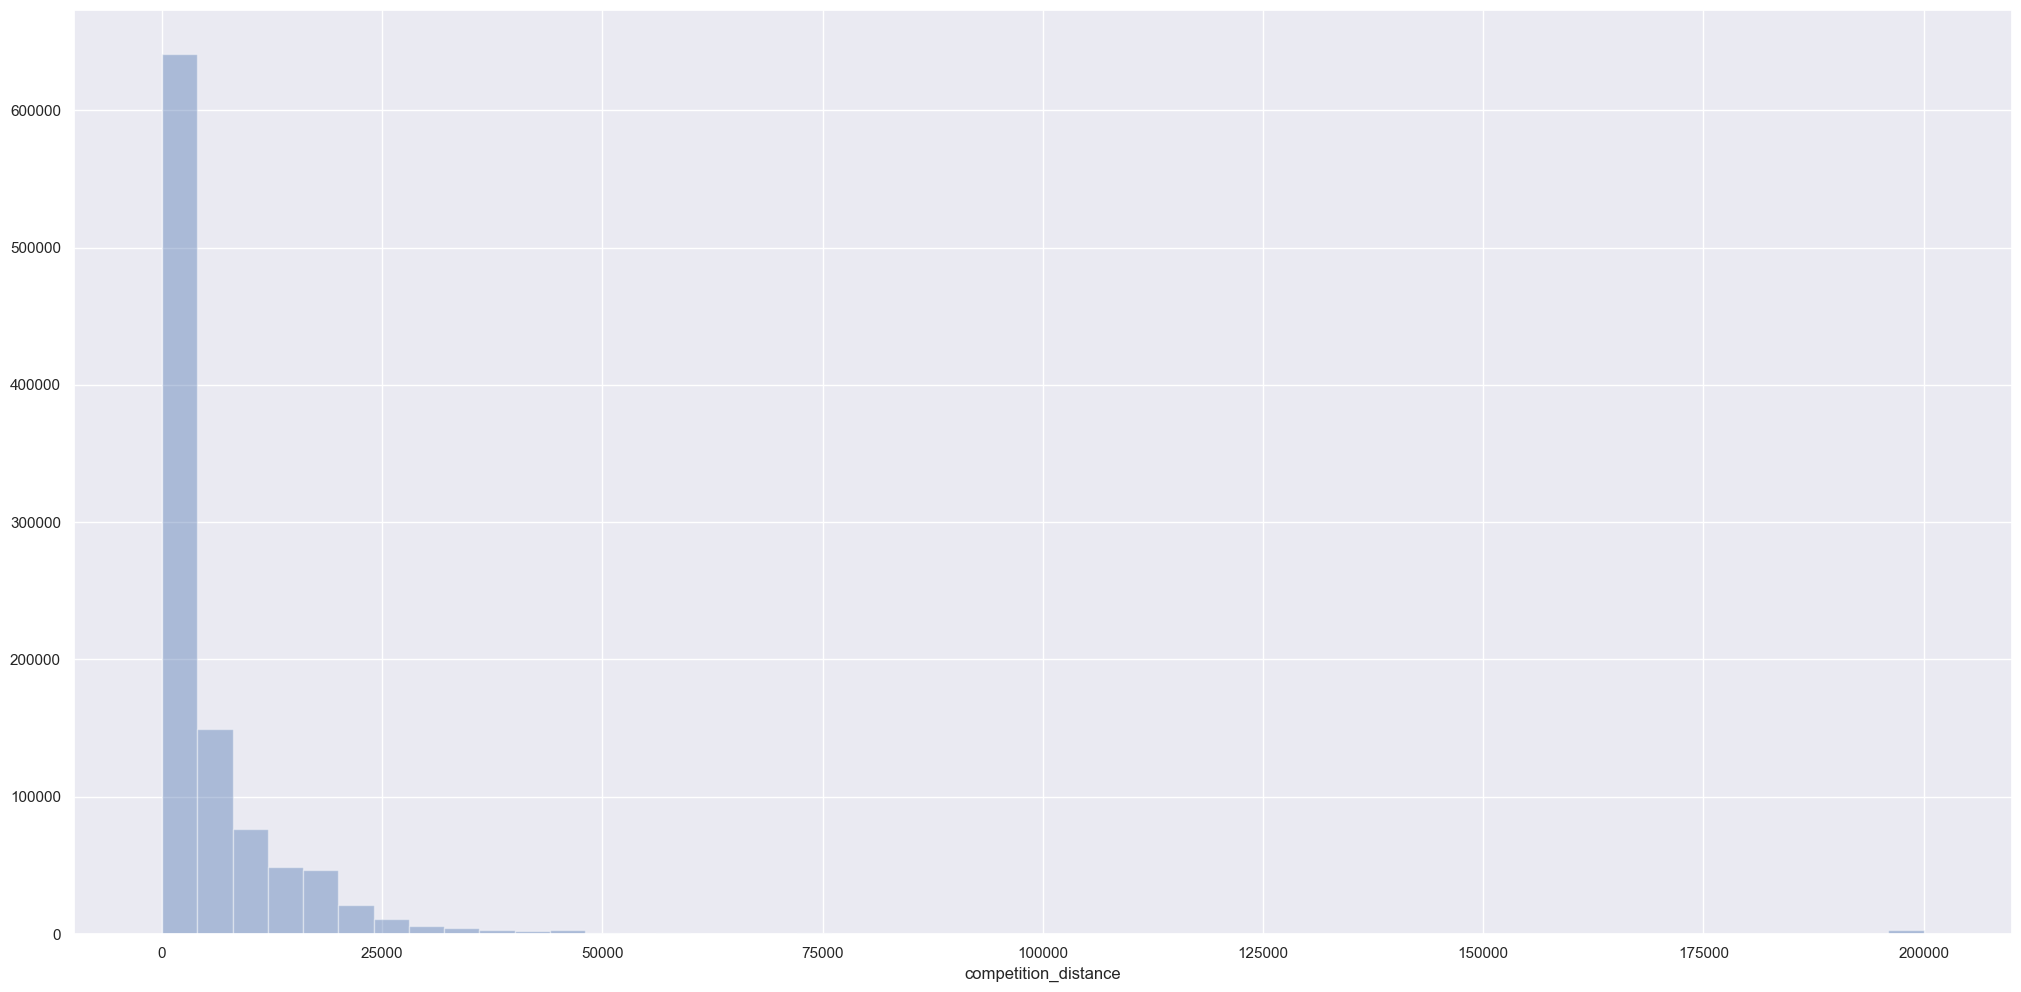

In [163]:
sns.distplot( df1['competition_distance'], kde=False ) #as distancias entre competidores é pequena, por isso existe a concentração proxima a zero, uma skew e kurtois alta. 

1.8.3. Categorical Attributes

In [164]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

c:\Users\Leticia Furletti\anaconda3\envs\Data_science\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Leticia Furletti\anaconda3\envs\Data_science\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Leticia Furletti\anaconda3\envs\Data_science\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Leticia Furletti\anaconda3\envs\Data_science\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Axes: xlabel='assortment', ylabel='sales'>

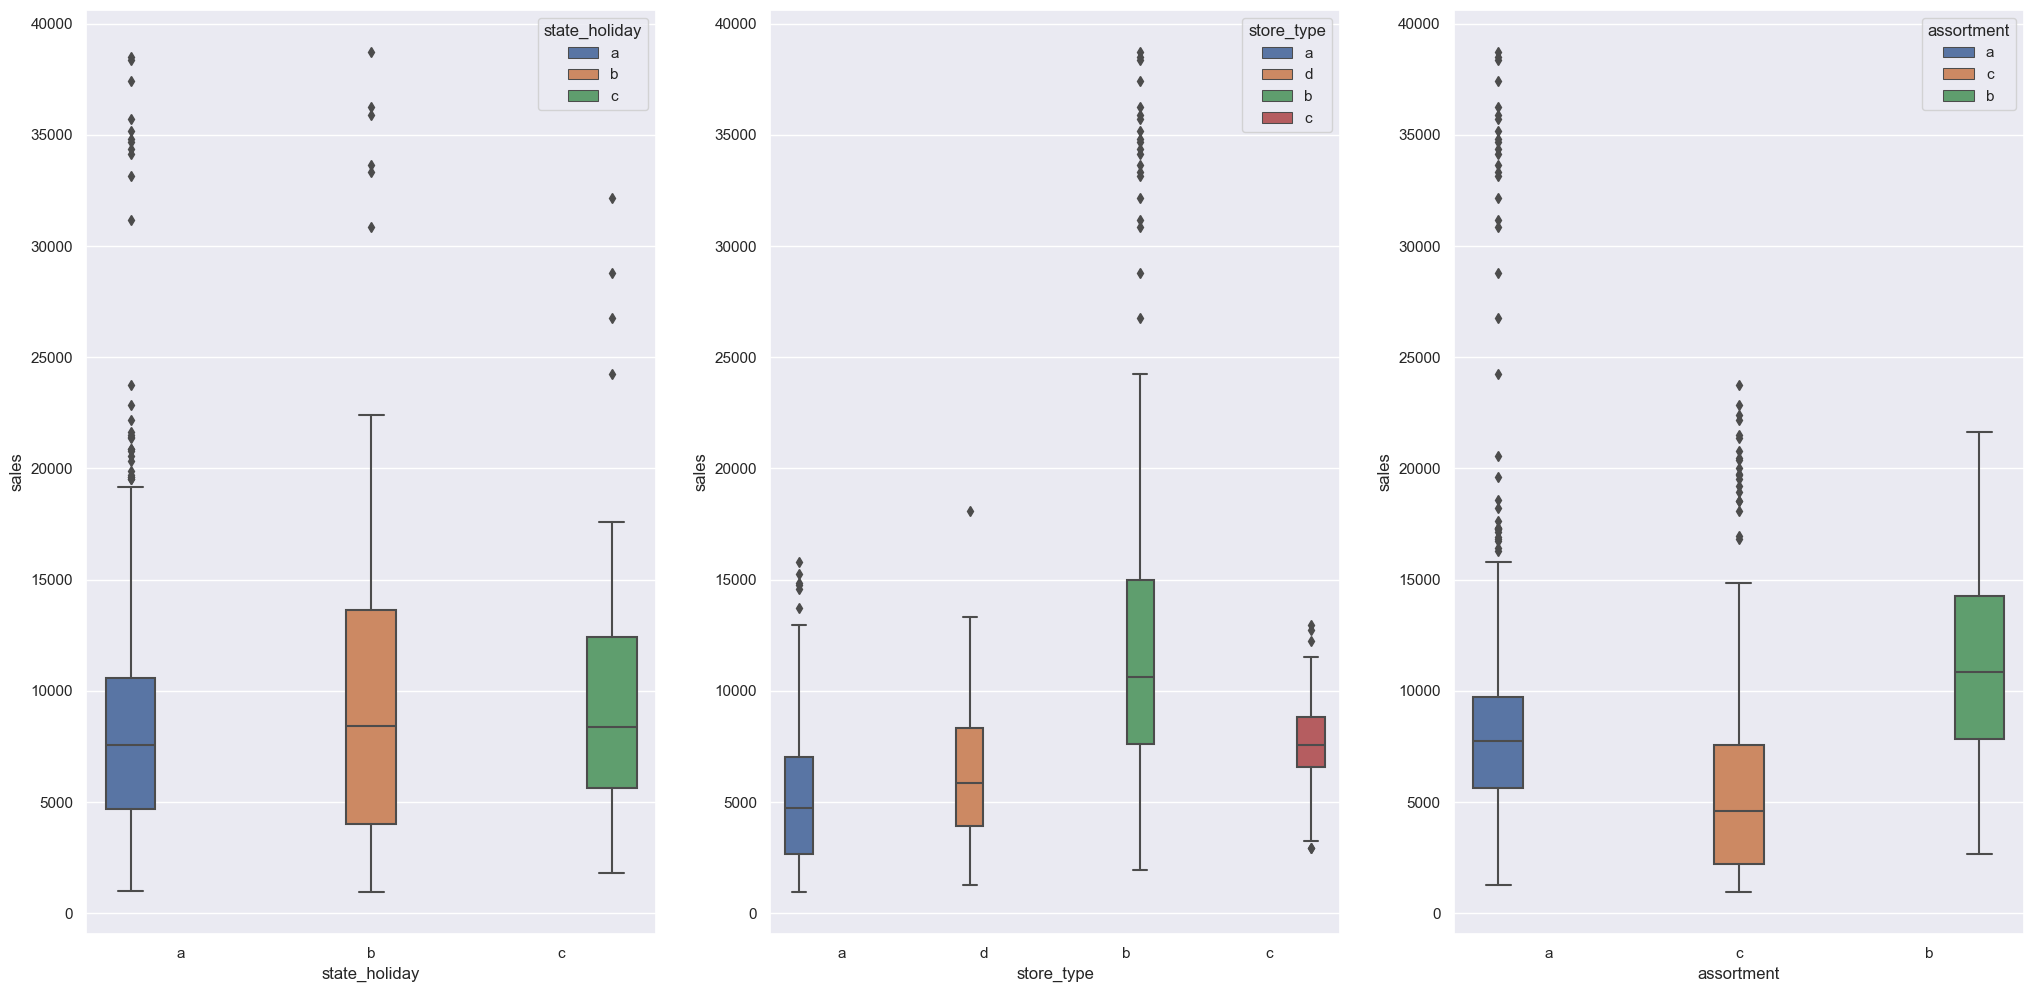

In [165]:
#quero saber como esta a disperção das vendas em cada ponto da variavel categorica (feriados estaduais)
aux1 = df1[ (df1['sales'] > 0) & (df1['state_holiday'] != '0') ] #(vendas maior que zero, e feriados estaduais diferente de zero)

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', hue='state_holiday', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', hue='store_type', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', hue='assortment', data=aux1)

2.0. FEATURE ENGINEERING

In [166]:
df2 = df1.copy()

2.1. Mind Map Hypothesis

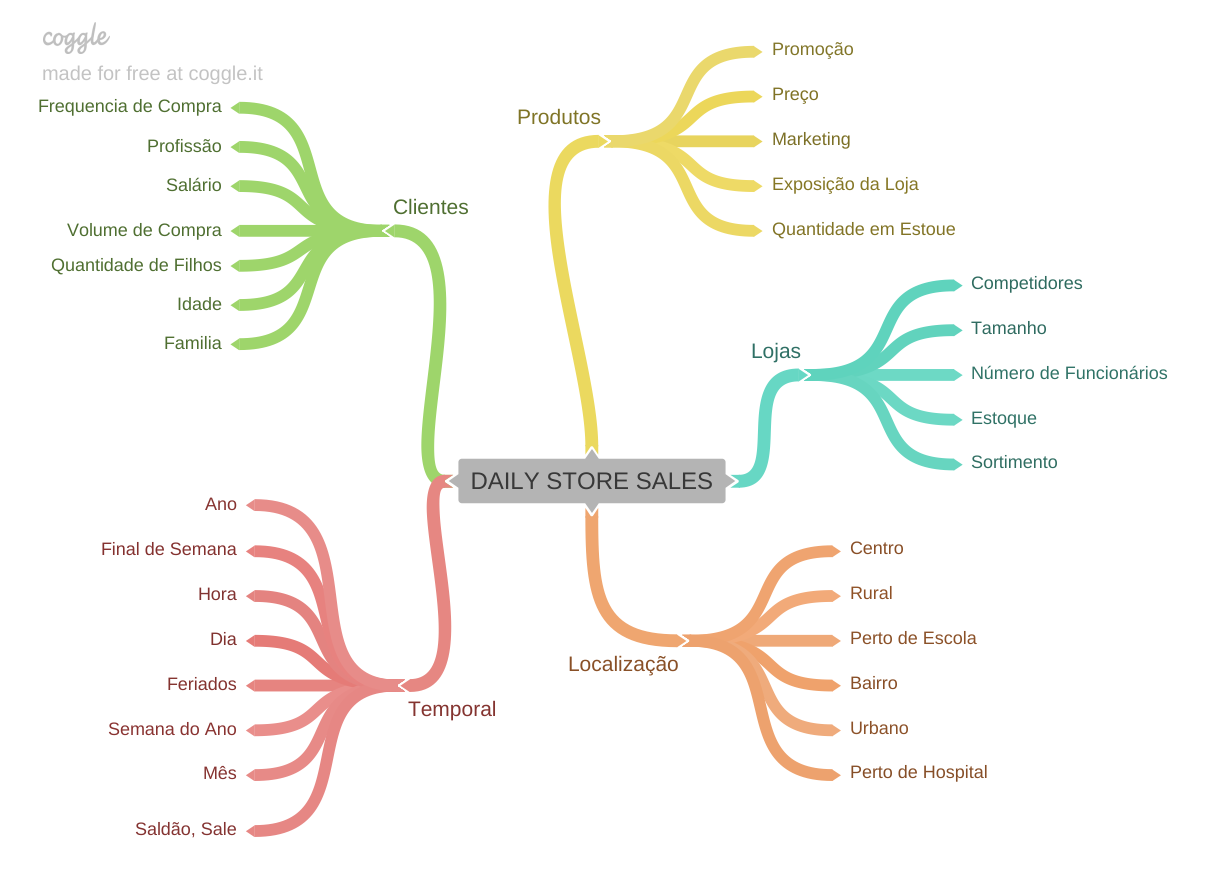

In [167]:
Image(r'C:\Users\Leticia Furletti\Repos\DATA_SCIENCE\Comunidade_Ds\DS_em_producao\mindmap.png')

2.2. Hypotesis

2.2.1. Store Hypotesis

1. Lojas com Maior Número de funcionários deveriam vender mais

Não possuímos a quantidade de funcionários no Dataset

2. Lojas com maior capacidade de estoque maior deveriam vender mais

Não possuímos o tamanho do estoque no Dataset

3. Lojas com maior porte deveriam vender mais

Não possuímos o porte da loja no Dataset

4. Lojas com maior sortimento de produtos vender mais

Possuímos o tipo de sortimento das lojas, separadas por categorias. Coluna Assortment

5. Lojas com competidores mais próximos deveriam vender menos

Possuímos a distancia das lojas e seus competidores mais próximos. Coluna CompetitionDistance

6. Lojas com competidores à mais tempo deveriam vender mais

Possuímos o tempo decorrido da abertura dos competidores perto das lojas. Colunas competition_open_since_month e competition_open_since_year 

2.2.2. Product Hypotesis

1. Lojas que investem mais em marketing deveriam vender mais

Não possuímos o budget de investimento em marketing das lojas no Dataset

2. Lojas com maior exposição dos produtos deveriam vender mais

Não possuímos a quantidade de produtos expostas nas lojas no Dataset

3. Lojas com produtos com preços menores deveriam vender mais

Não possuímos o preço dos produtos das lojas no Dataset

4. Lojas com descontos mais agressios (preços menores) deveriam vender mais

Não possuímos o valor do descont das lojas no Dataset

5. Lojas com promoções ativas por mais tempo deveriam vender mais

Possuímos colunas para verificar o tempo decorrido que uma loja esteve em promoção. Colunas Promo2 , promo2_since_week , promo2_since_year, PromoInterval

6. Lojas com mais dias em promoção deveriam vender mais

Possuímos colunas para verificar o tempo decorrido que uma loja esteve em promoção. Colunas Promo2 , promo2_since_week , promo2_since_year , PromoInterval

7. Lojas com mais promoções consecutivas deveriam vender mais

Possuímos colunas para verificar o tempo decorrido que uma loja esteve em promoção. Colunas Promo2 , promo2_since_week , promo2_since_year , PromoInterval

2.2.3. Temporal Hypotesis

1. Lojas abertas durante o feriado de Natal deveriam vender mais

Possuímos colunas para verificar se as lojas estiveram abertas em feriados e em quais feriados. Colunas Open , StateHoliday

2. Lojas deveriam vender mais ao longo dos anos

Possuímos uma coluna que pode ser derivada e criada uma nova coluna para validarmos essa hipótese. Coluna date

3. Lojas deveriam vender mais no segundo semestre do ano

Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna date

4. Lojas deveriam vender mais depois do dia 10 de cada mês

Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna date

5. Lojas deveriam vender menos aos finais de semana

Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna date

6. Lojas deveriam vender menos durante os feriados escolares

Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna date

2.3. Chosen Hypotesis (baseado nos dados que o dataset me fornece p analise)

1. Lojas com maior sortimento de produtos vender mais

2. Lojas com competidores mais próximos deveriam vender menos

3. Lojas com competidores à mais tempo deveriam vender mais

4. Lojas com prmnoções ativas por mais tempo deveriam vender mais

5. Lojas com mais dias em promoção deveriam vender mais

6. Lojas com mais promoções consecutivas deveriam vender mais

7. Lojas abertas durante o feriado de Natal deveriam vender mais

8. Lojas deveriam vender mais ao longo dos anos

9. Lojas deveriam vender mais no segundo semestre do ano

10. Lojas deveriam vender mais depois do dia 10 de cada mês

11. Lojas deveriam vender menos aos finais de semana

12. Lojas deveriam vender menos durante os feriados escolares

13. Lojas deveriam vender menos durante os feriados escolares.


2.4. Feature Engineering #derivando features apartir da variavel original (utilizando as descrições de cada variavel, que pontuei no inicio do codigo)

In [168]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [169]:
df2.sample(5).T

,568857,651211,669213,320814,986356
store,993,837,999,343,367
day_of_week,5,1,6,4,1
date,2014-02-07 00:00:00,2013-11-25 00:00:00,2013-11-09 00:00:00,2014-10-02 00:00:00,2013-01-28 00:00:00
sales,8244,2281,6392,9058,3239
customers,837,366,489,903,397
open,1,1,1,1,1
promo,1,0,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,d,a,d,d,d


3.0. FILTERING FEATURES


In [171]:
df3 = df2.copy()

3.1. Filtering Lines

In [172]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

3.2. Columns Selection

In [173]:
#selecionando os dados que não irei trabalhar (retirando colunas auxiliares que criamos no inicio do codigo)
cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] 

In [174]:
#deletando as colunas selecionada (axis=1 são colunas, axis=0 linhas)
df3.drop(cols_drop, axis=1, inplace=True)

4.0. EDA - EXPLORATORY DATA ANALYSIS

In [339]:
df4 = df3.copy()


4.1. Univariate Analysis

4.1.1. Response Variable
quanto mais proximo de distribuição normal minha variavel resposta melhor a performance do algoritimo

<Axes: xlabel='sales', ylabel='Density'>

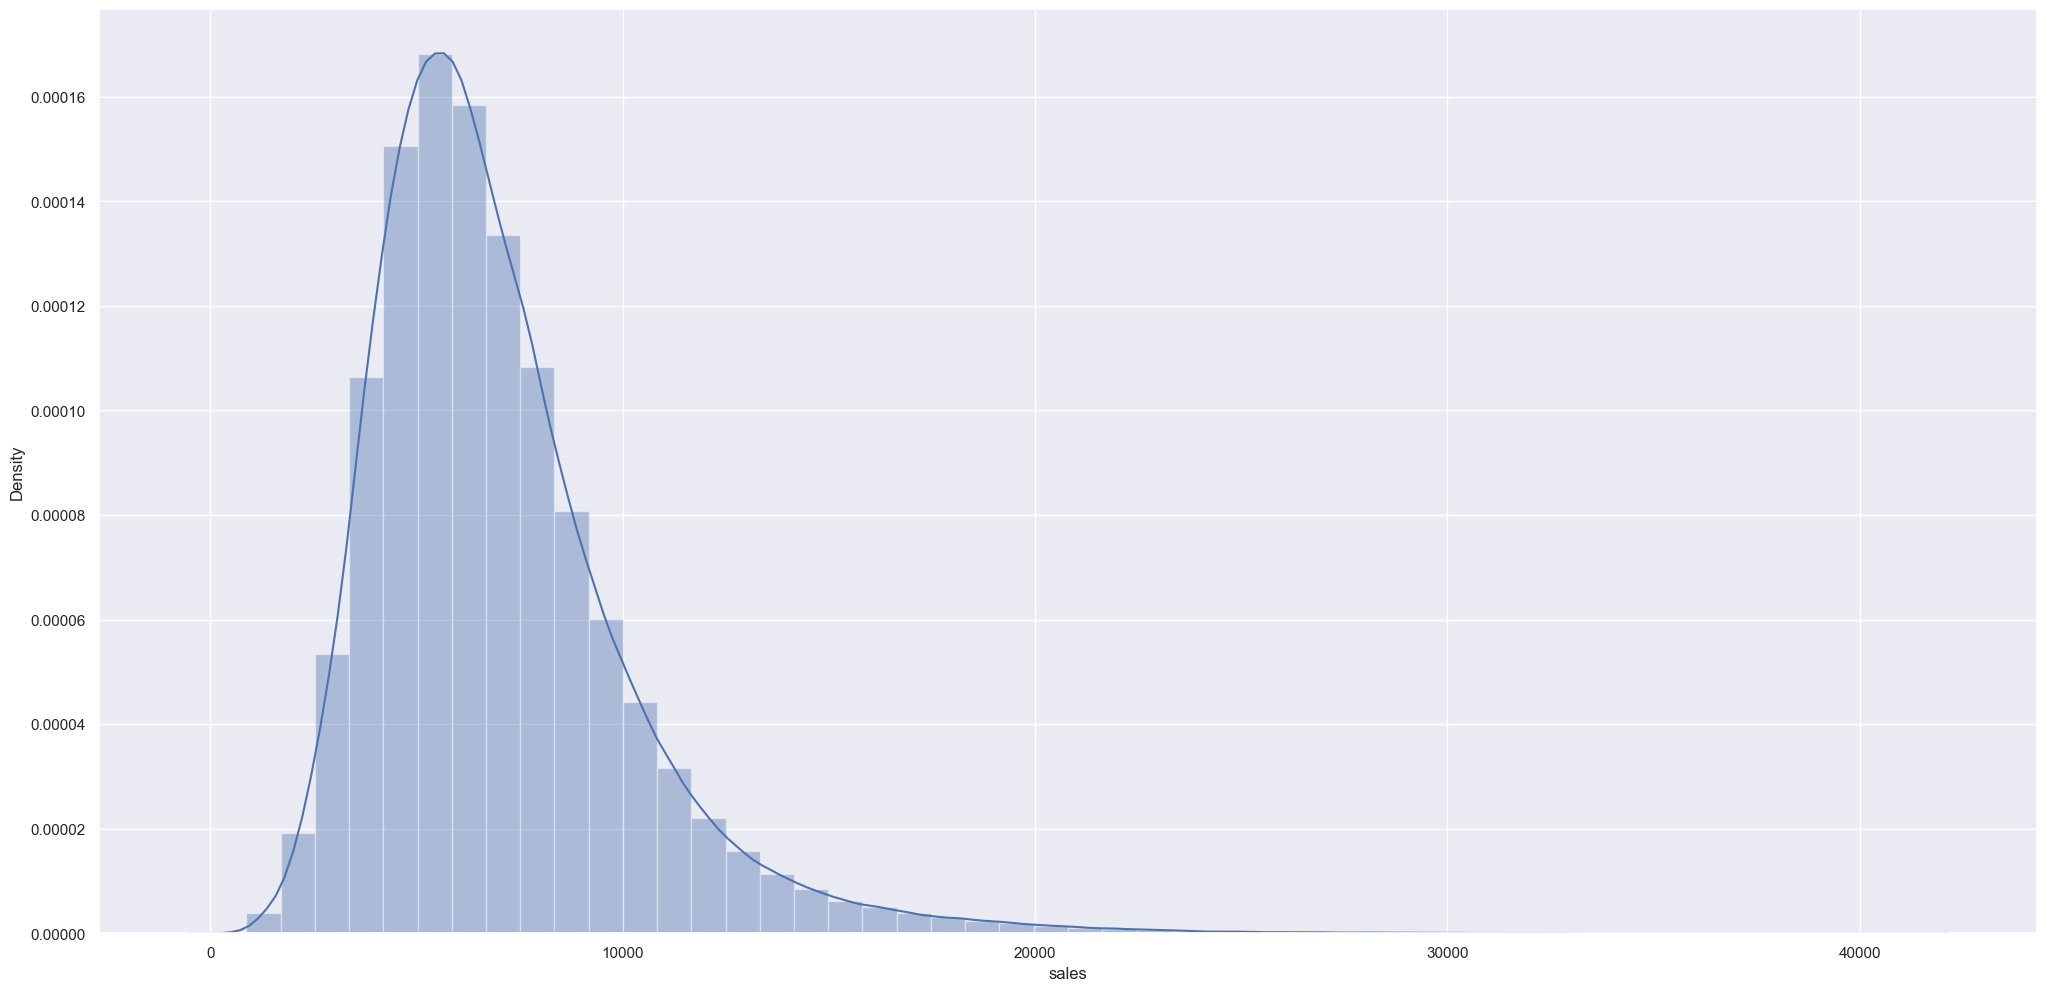

In [340]:
sns.distplot(df4['sales'])

4.1.2. Numerical Variable


array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

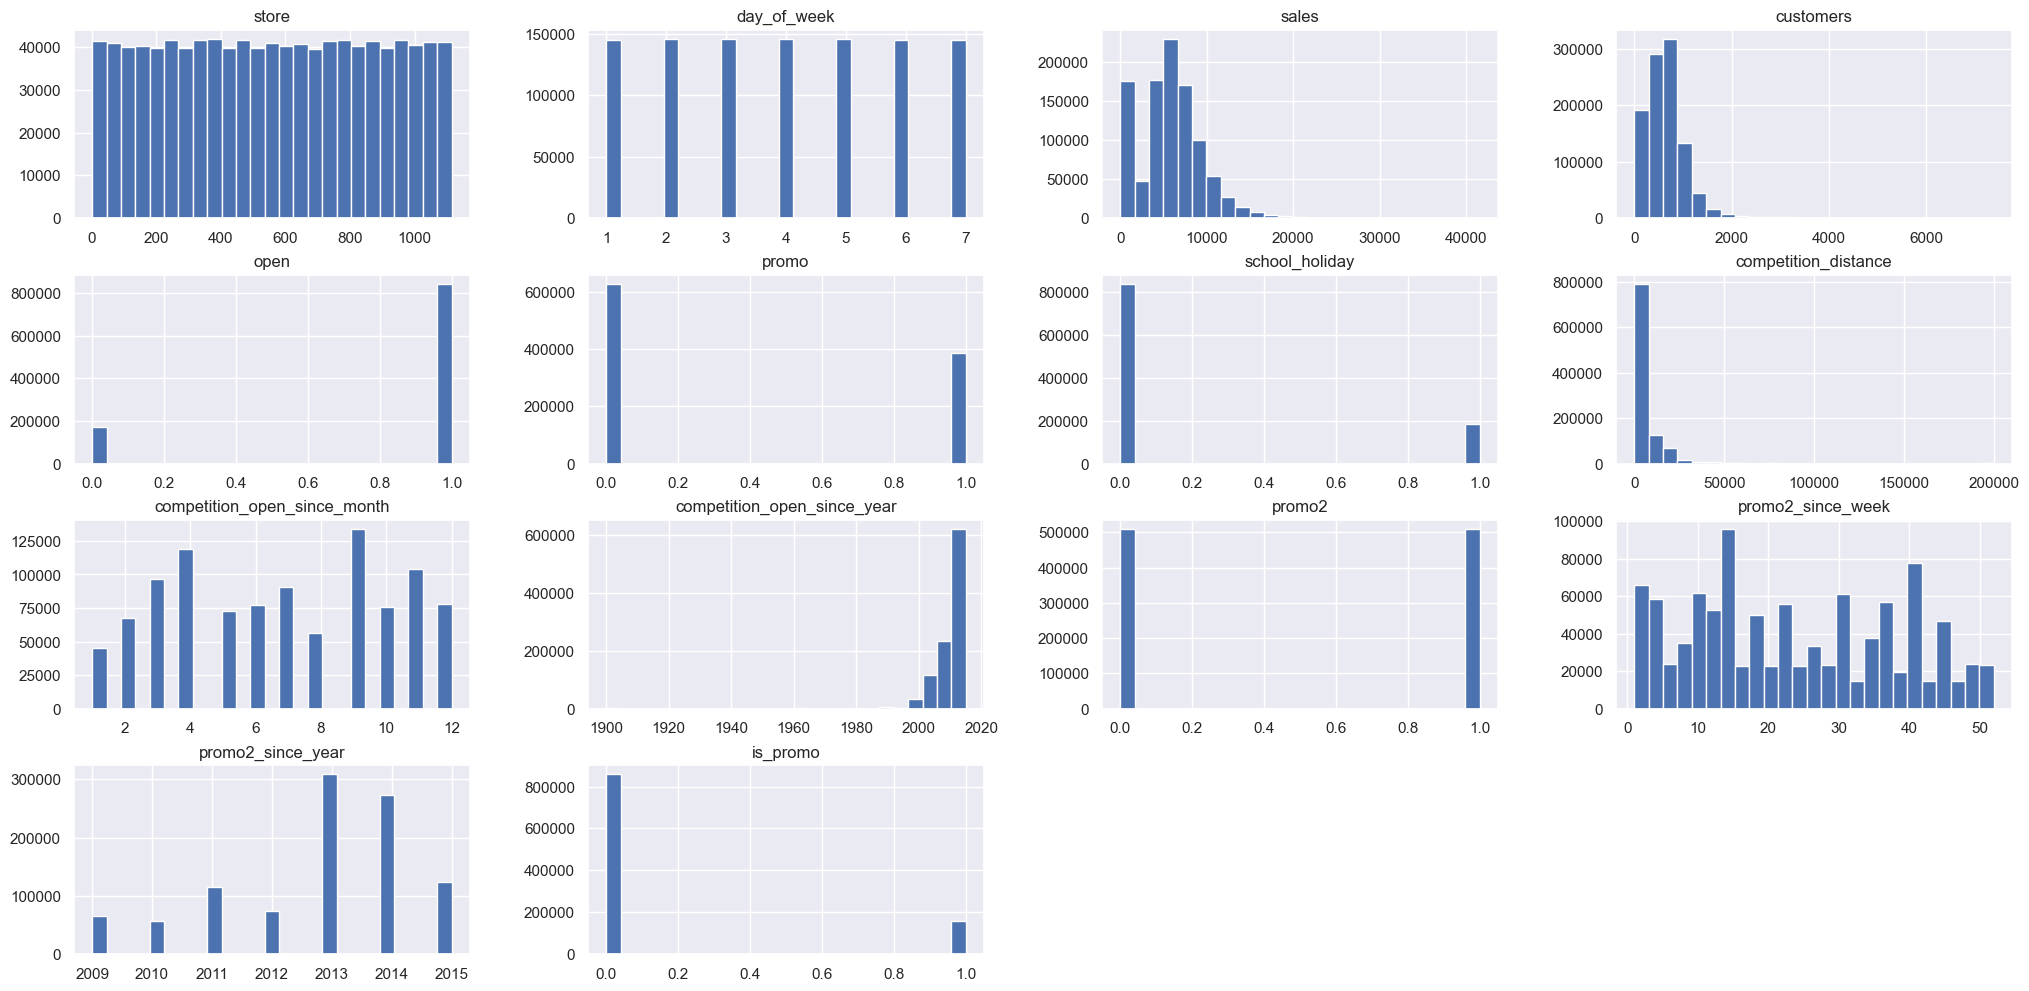

In [341]:
num_attributes.hist(bins=25)

4.1.3. Categorical Variables

In [342]:
df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

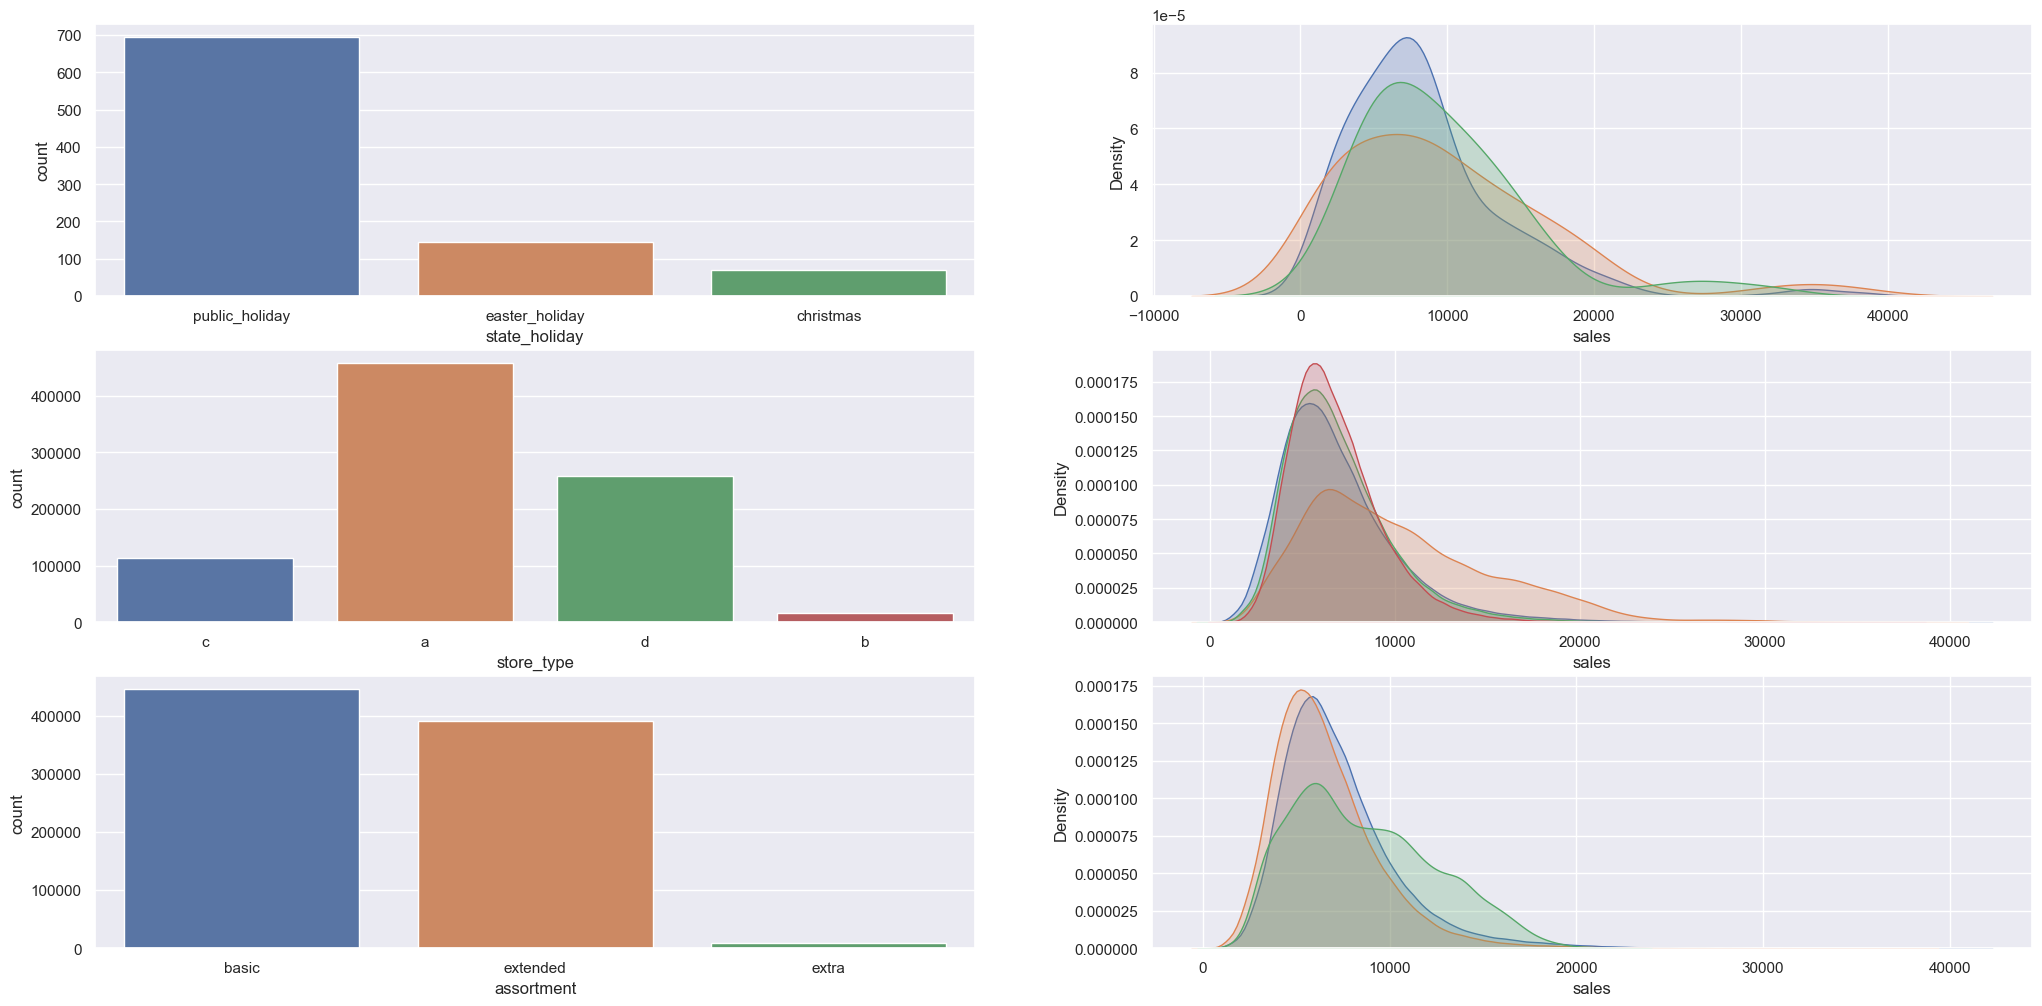

In [343]:
 # state_holiday
# state holliday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day'] #para incluir apenas os dias que não são "regular_day" e armazena na variável a
sns.countplot(x= a['state_holiday'] ) #contagem de cada tipo state holiday presente no DataFrame a

plt.subplot( 3, 2, 2 ) #Grafico de Estimativa de Densidade Kernel (KDE)(para visualizar a distribuição de dados contínuos) distribuição das vendas em feriados específicos (public_holiday, easter_holiday, christmas)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', shade=True )
 
 # store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x=df4['store_type'] )

 # assortment
plt.subplot( 3, 2, 5 )
sns.countplot(x= df4['assortment'] )
 
plt.subplot( 3, 2, 4 ) #distribuições de vendas em diferentes lojas (a, b, c e d)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
 
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True )

4.2. Bivariate Analysis #analisando minhas hipoteses

4.2.1. Hypotesis 1 - Lojas com maior sortimento de produtos vender mais
FALSA Lojas com MAIOR SORTIMENTO (extra) vendem MENOS

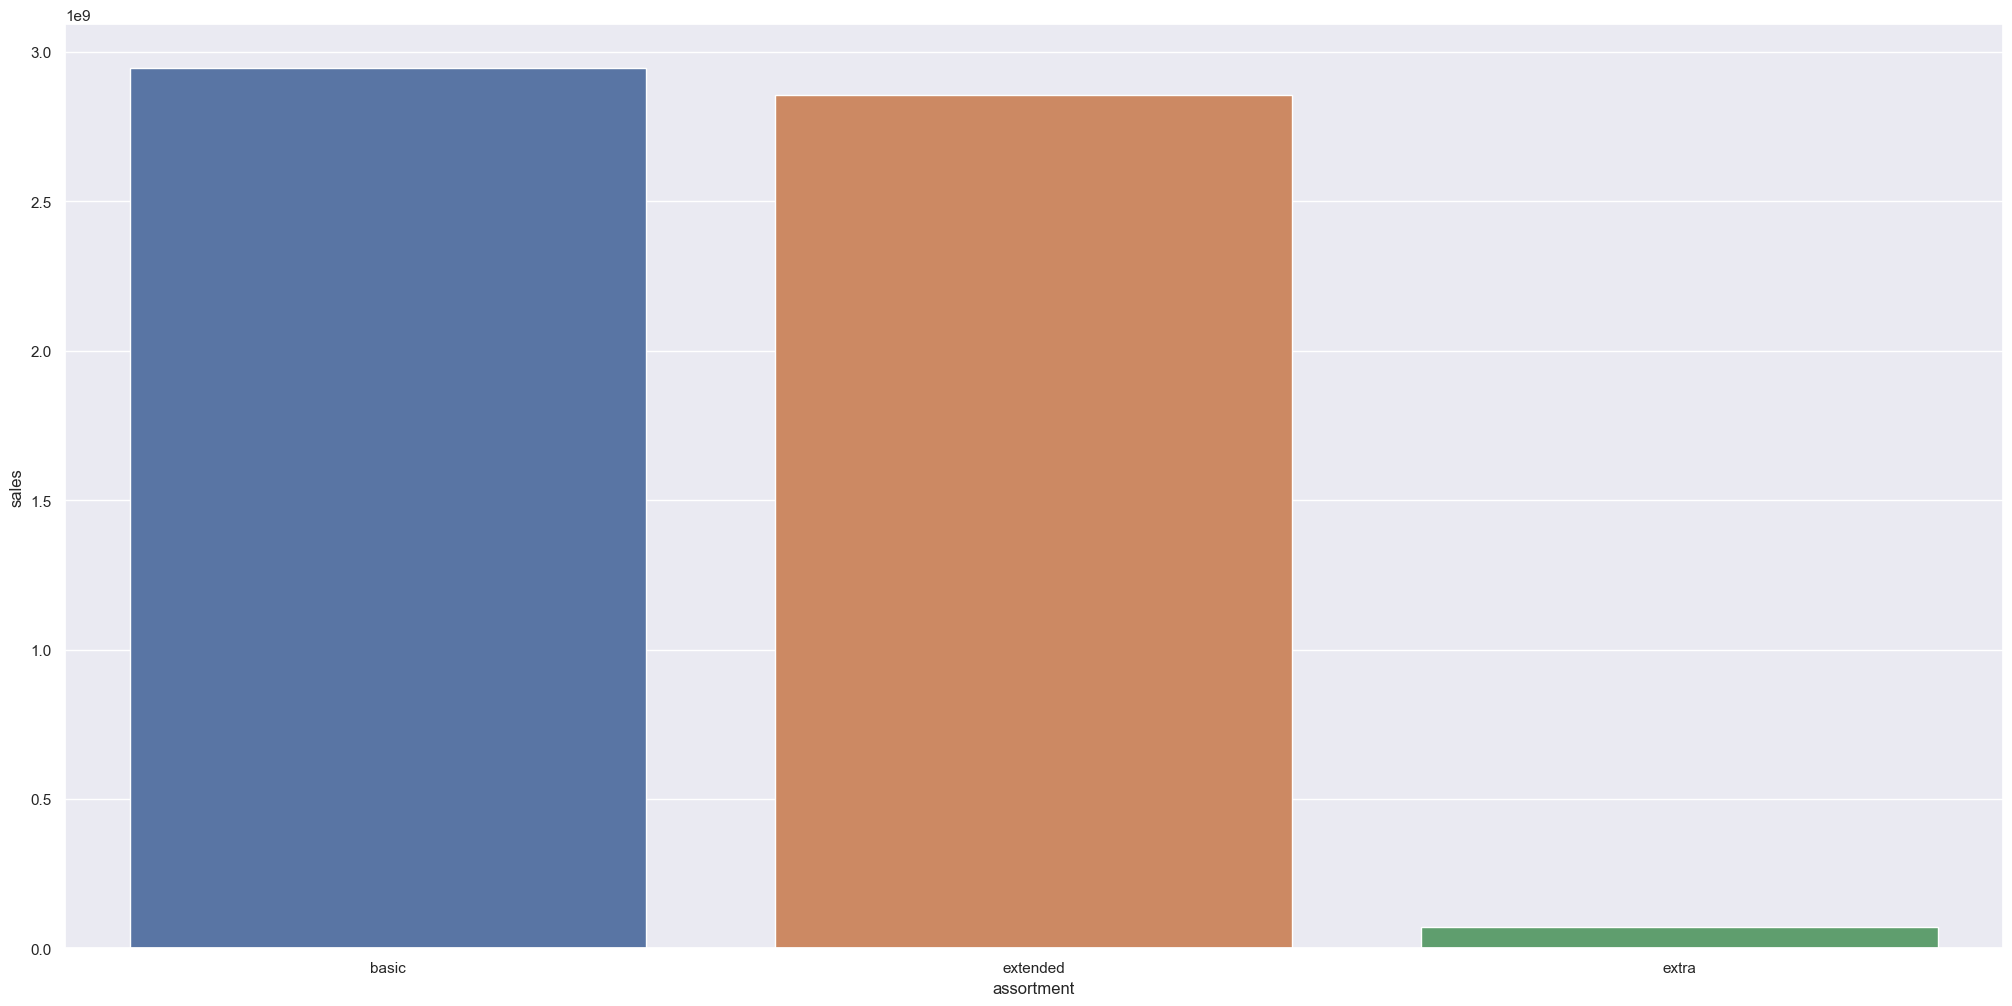

In [344]:
# Gráfico de Barras para comparar a soma das vendas por tipo de sortimento
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

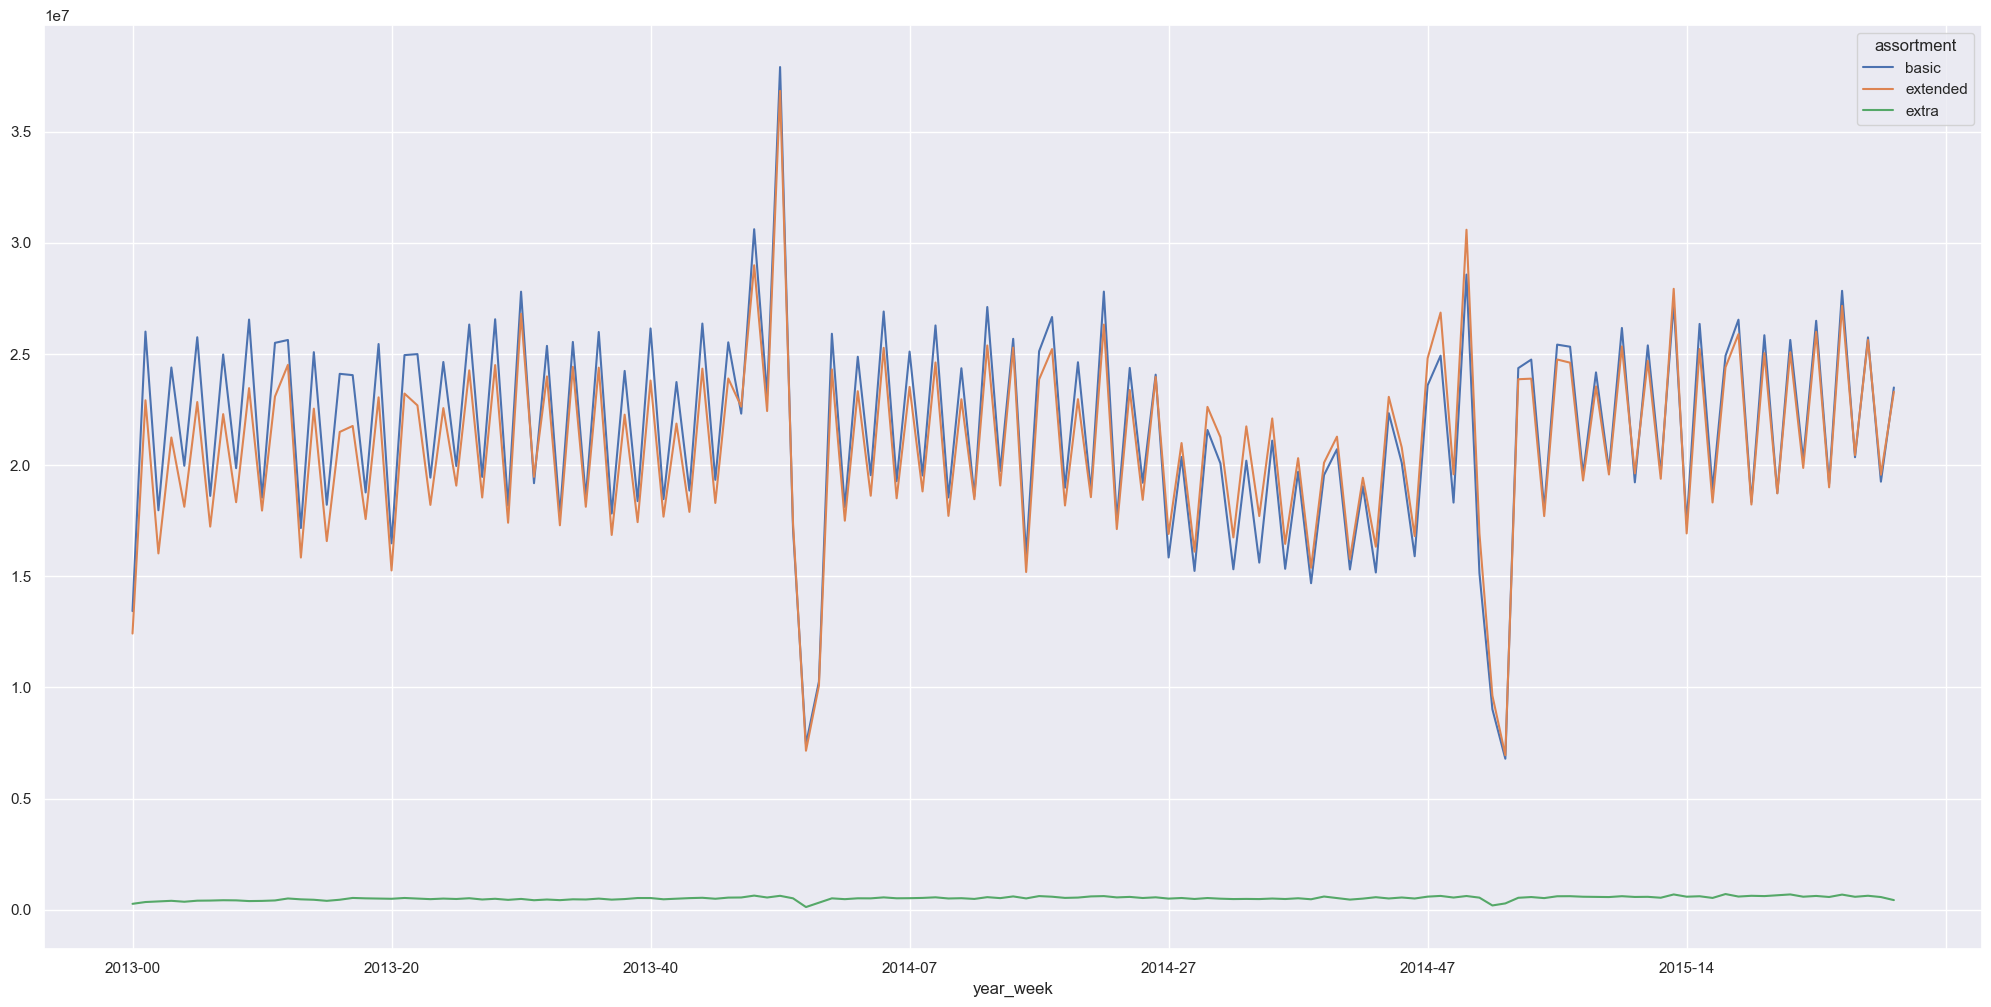

In [345]:
# Gráfico Temporal para demonstrar a variação das vendas por sortimento ao longo das semanas dos anos
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

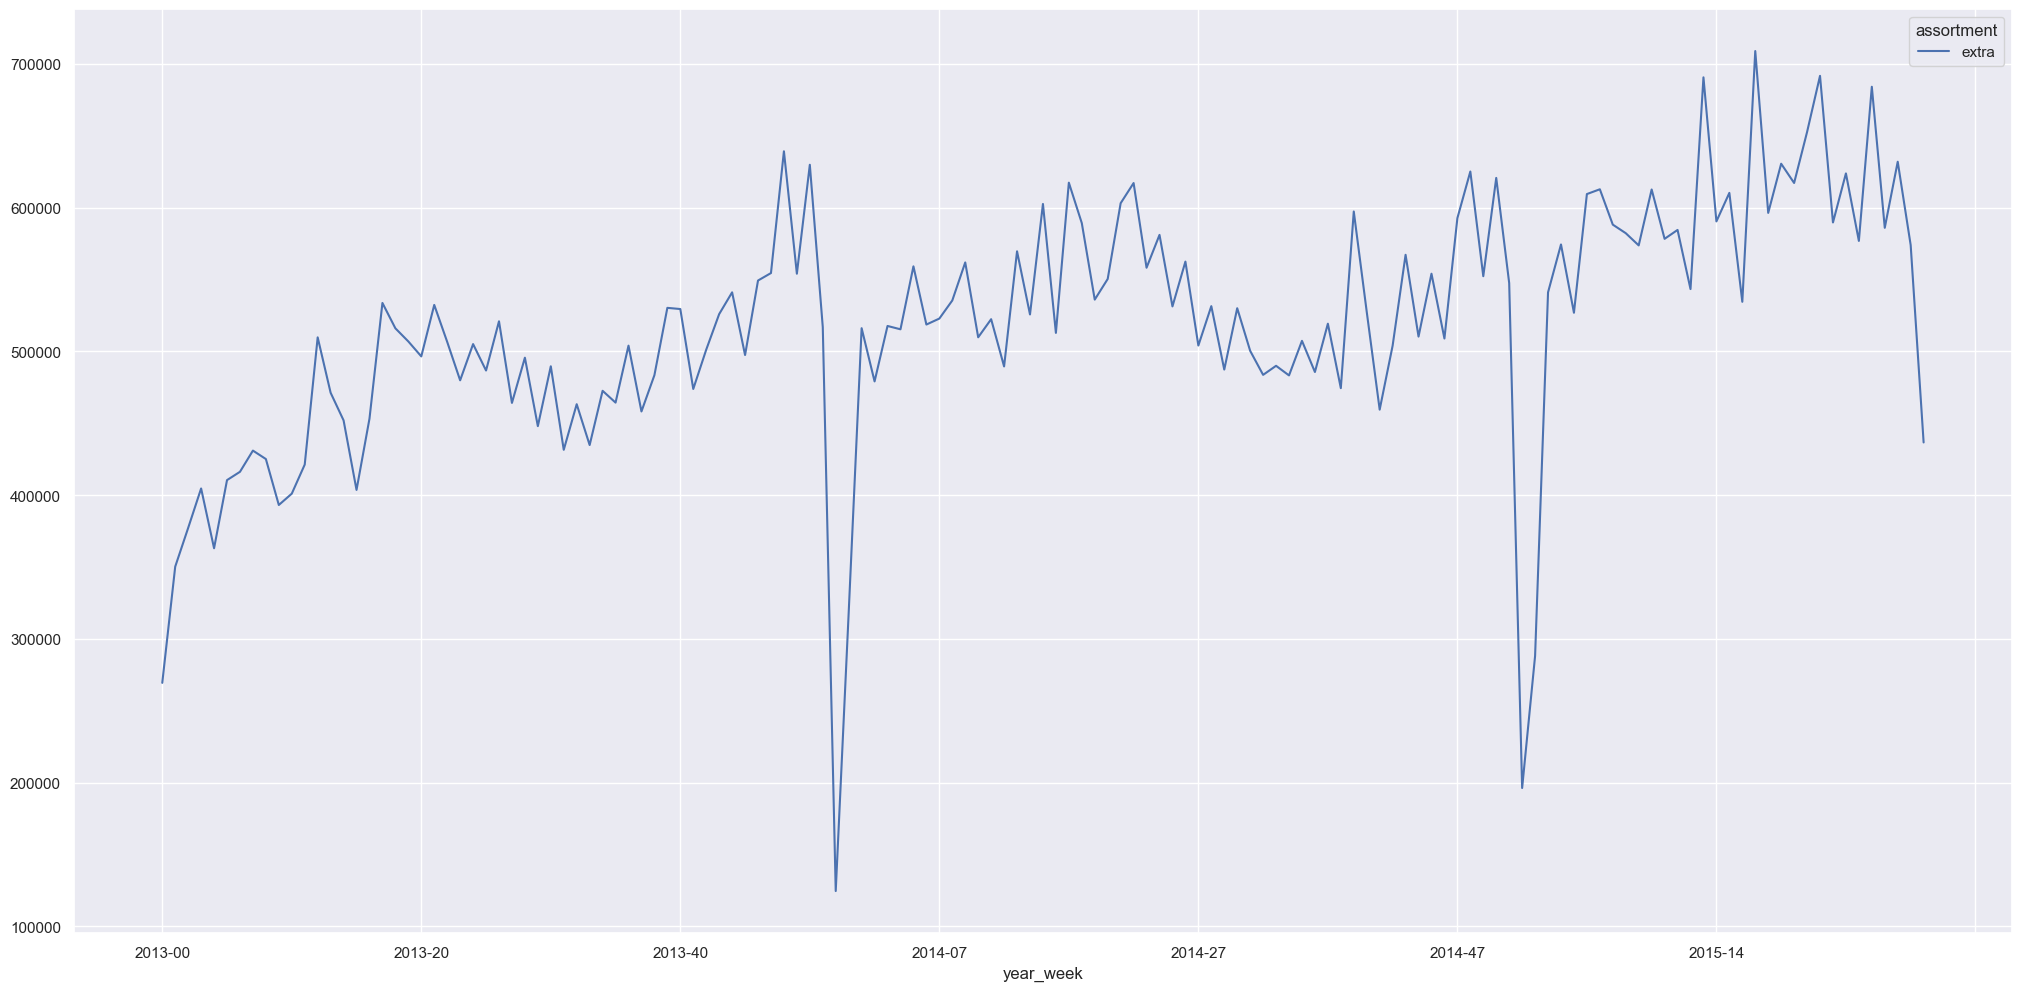

In [346]:
# Gráfico Temporal para mostrar a variação das vendas quando o sortimento for igual a extra
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

4.2.2. Hypotesis 2 - Lojas com competidores mais próximos deveriam vender menos
FALSA Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

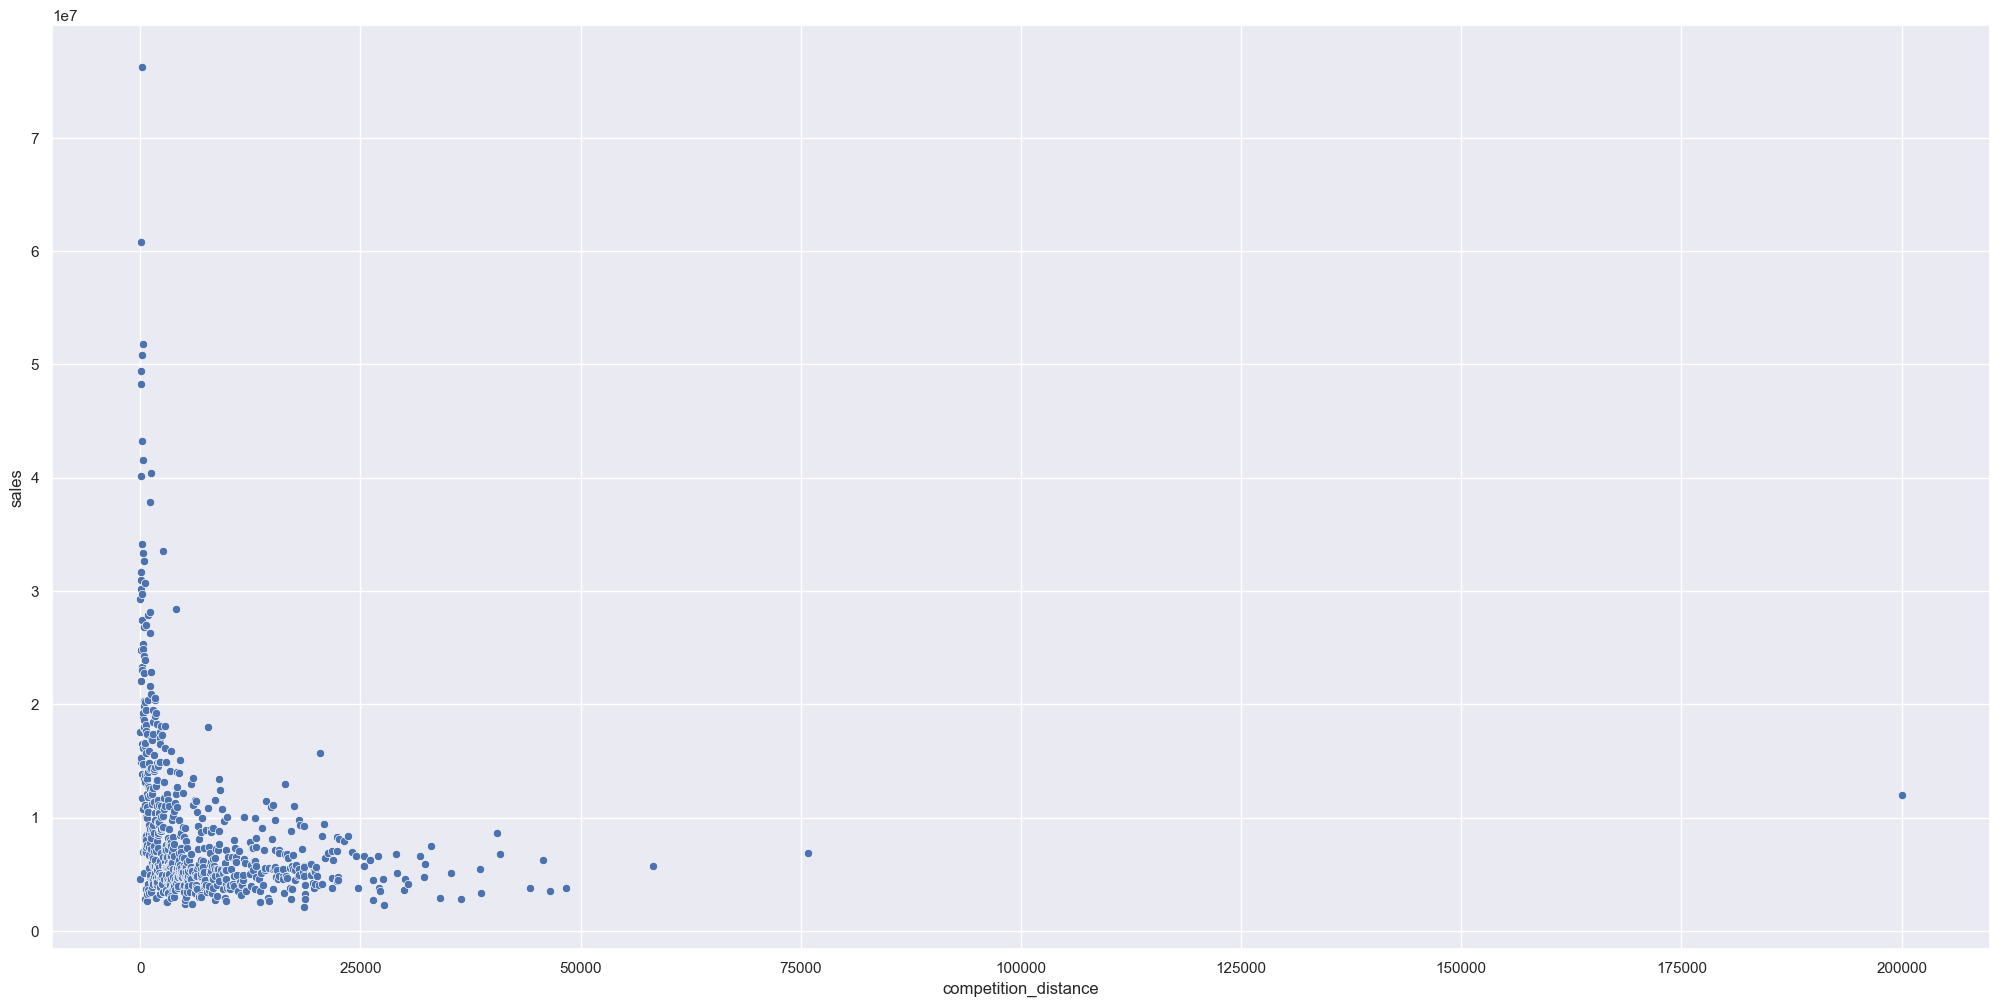

In [347]:
# Gráfico de Distribuição de ponto para verificarmos a distribuição das vendas em relação a distancia do competidor
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

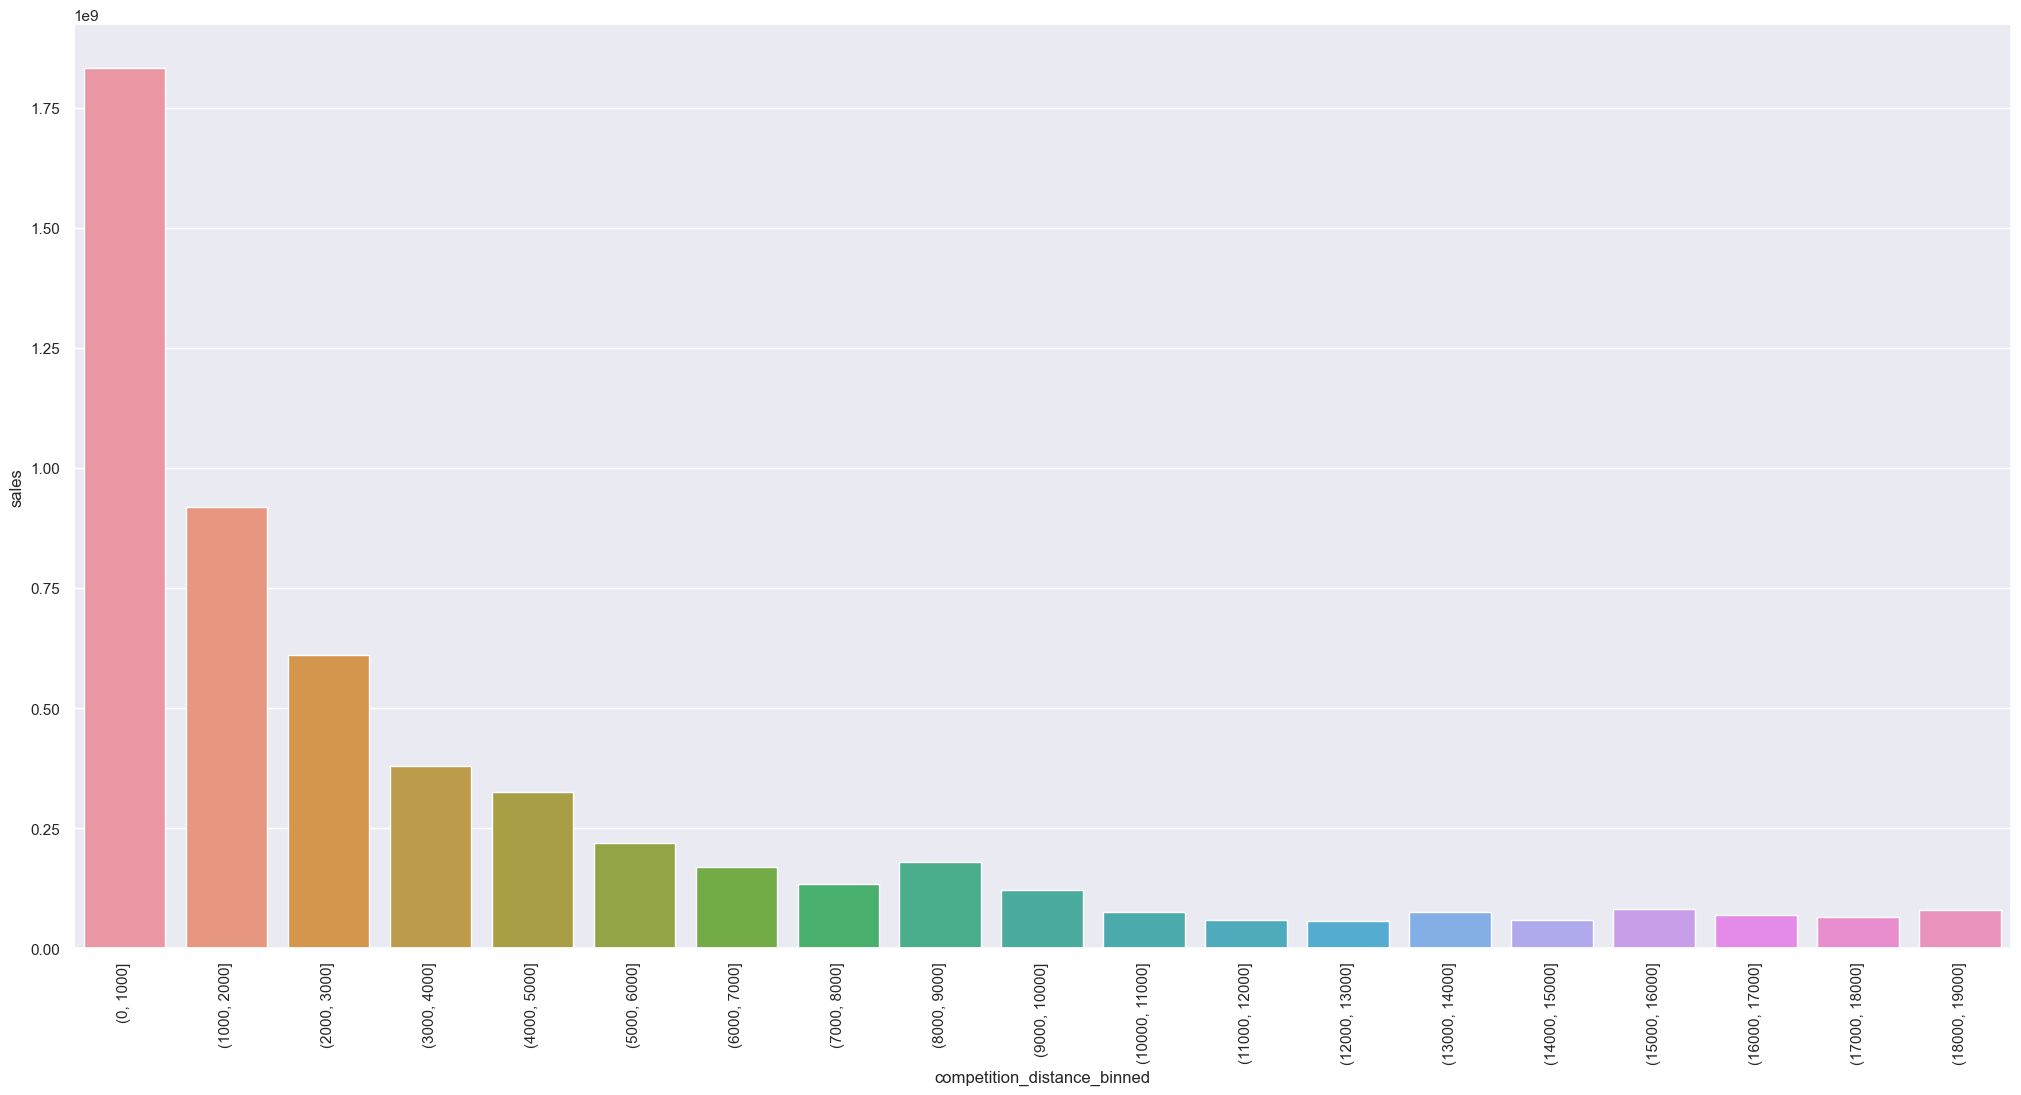

In [348]:
# Gráfico de Barras para podemor comparar a somatória das vendas por conjunto de competidores em certas distância
group = list(np.arange(0, 20000, 1000)) #separando em 'grupos' para facilitar a visualização
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=group)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

4.2.3. Hypotesis 3 - Lojas com competidores à mais tempo deveriam vender mais
FALSA Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS

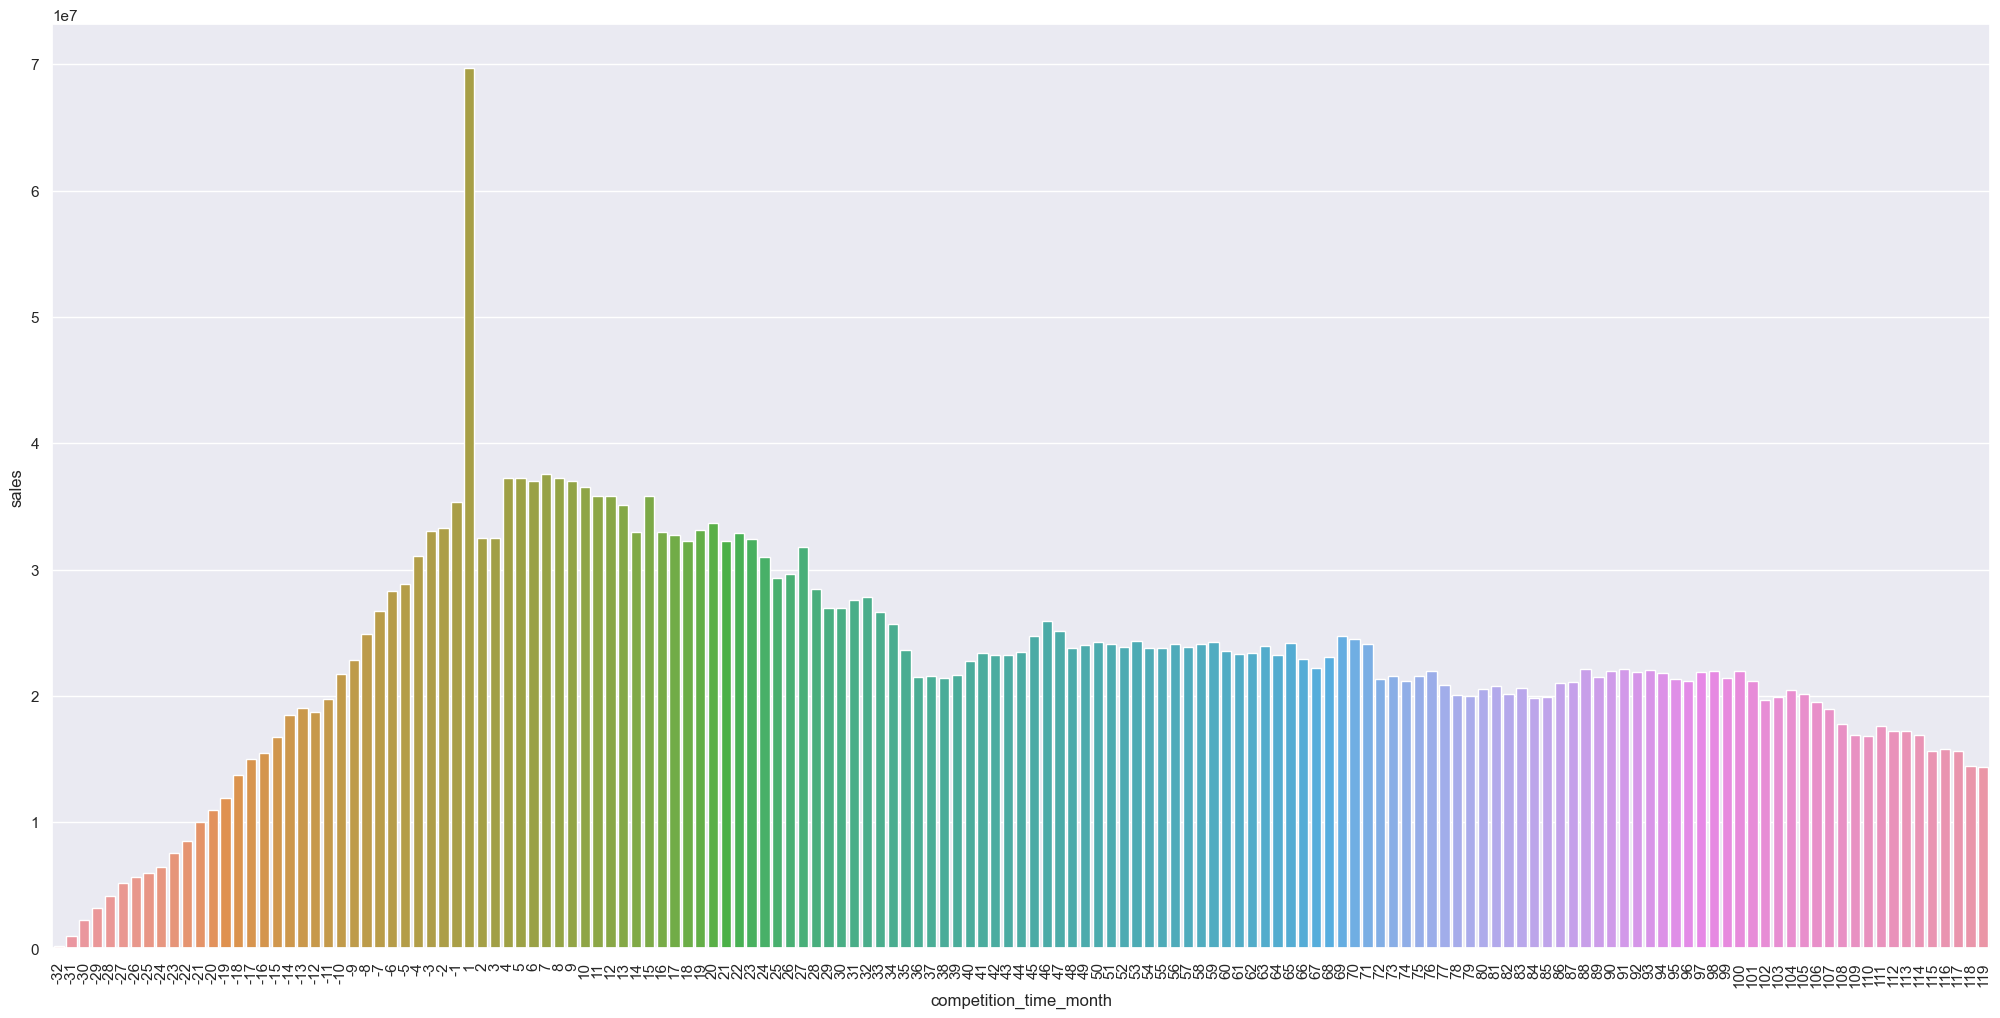

In [350]:
# Gráfico de Barras para compararmos as vendas conforme os concorrentes inauguravam suas lojas
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# 120 Primeiros meses de competição e Tempo de competição diferente de Zero
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

# Valores negativos do eixo X representam que o competidor abriu depois de a loja ja ter iniciado a venda.
# Enquanto os valores positivos representam que o competidor ja existia no local antes de a loja abrir
# Dessa forma, podemos notar que quanto mais recente é o tempo de competição, maior são as vendas

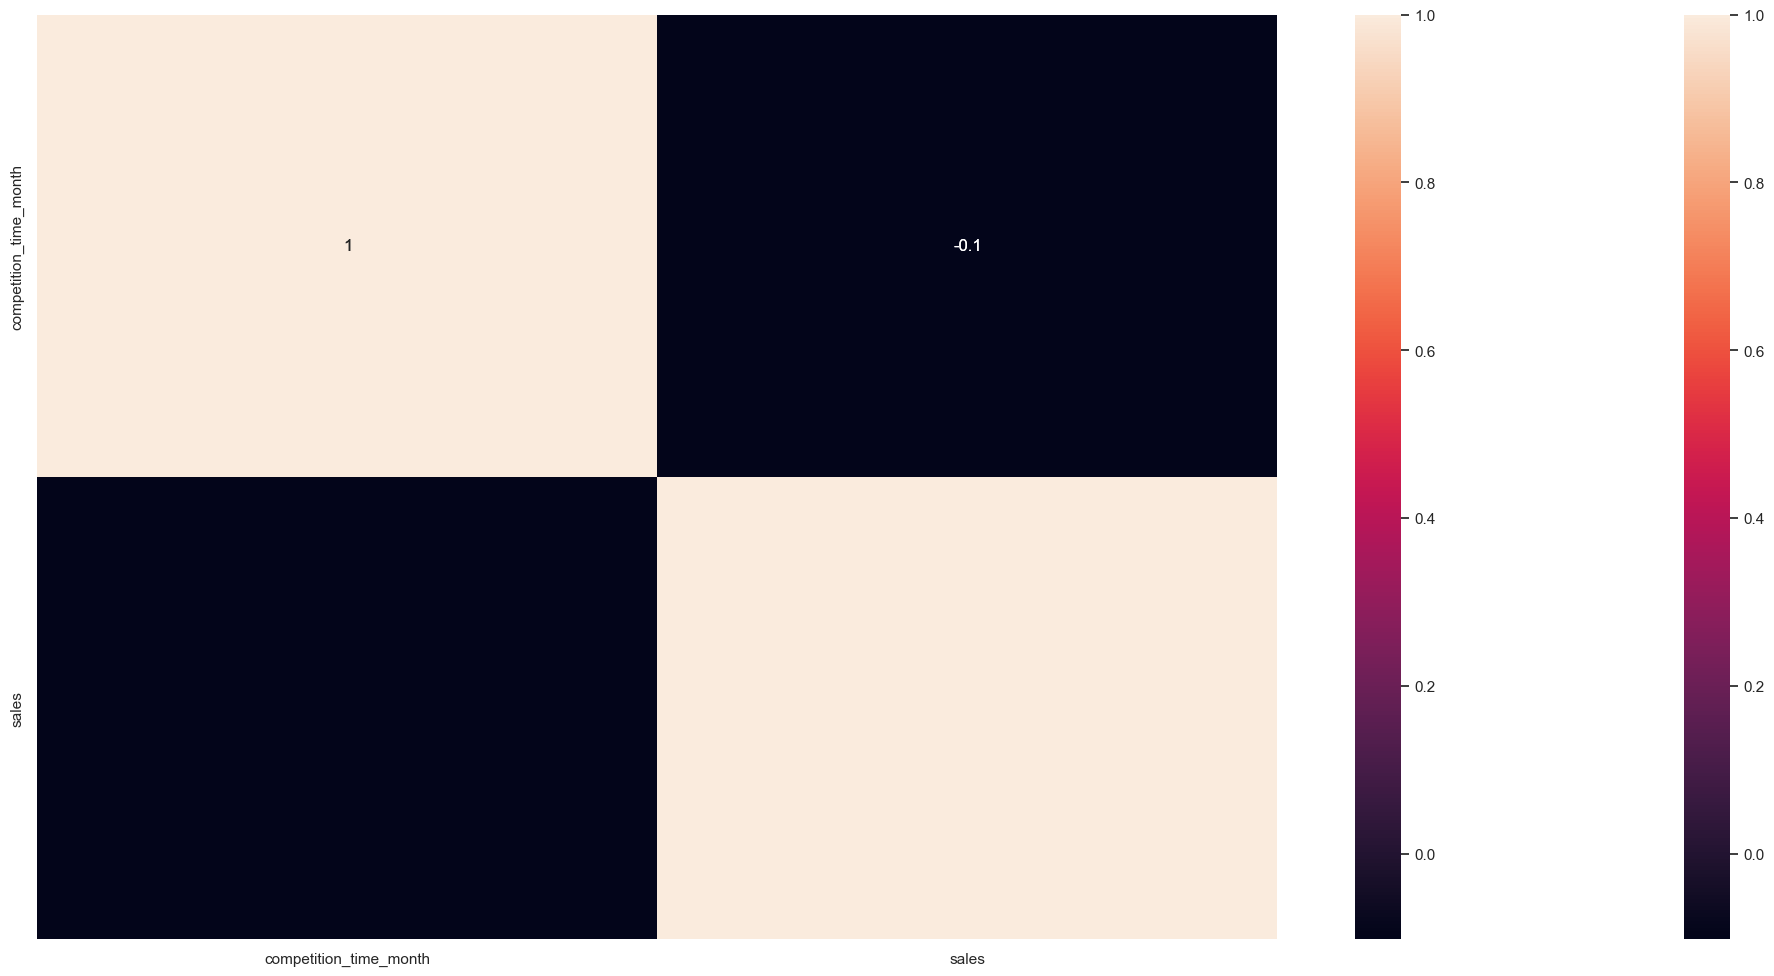

In [351]:
# Heatmap da correlação entre o tempo decorrido de competição com o valor das vendas
sns.heatmap(aux1.corr(method='pearson'), annot=True)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

4.2.4. Lojas com promnoções ativas por mais tempo deveriam vender mais
FALSA lojas com PROMOÇÕES ATIVAS por mais tempo vendem MENOS, depois de um certo período de tempo



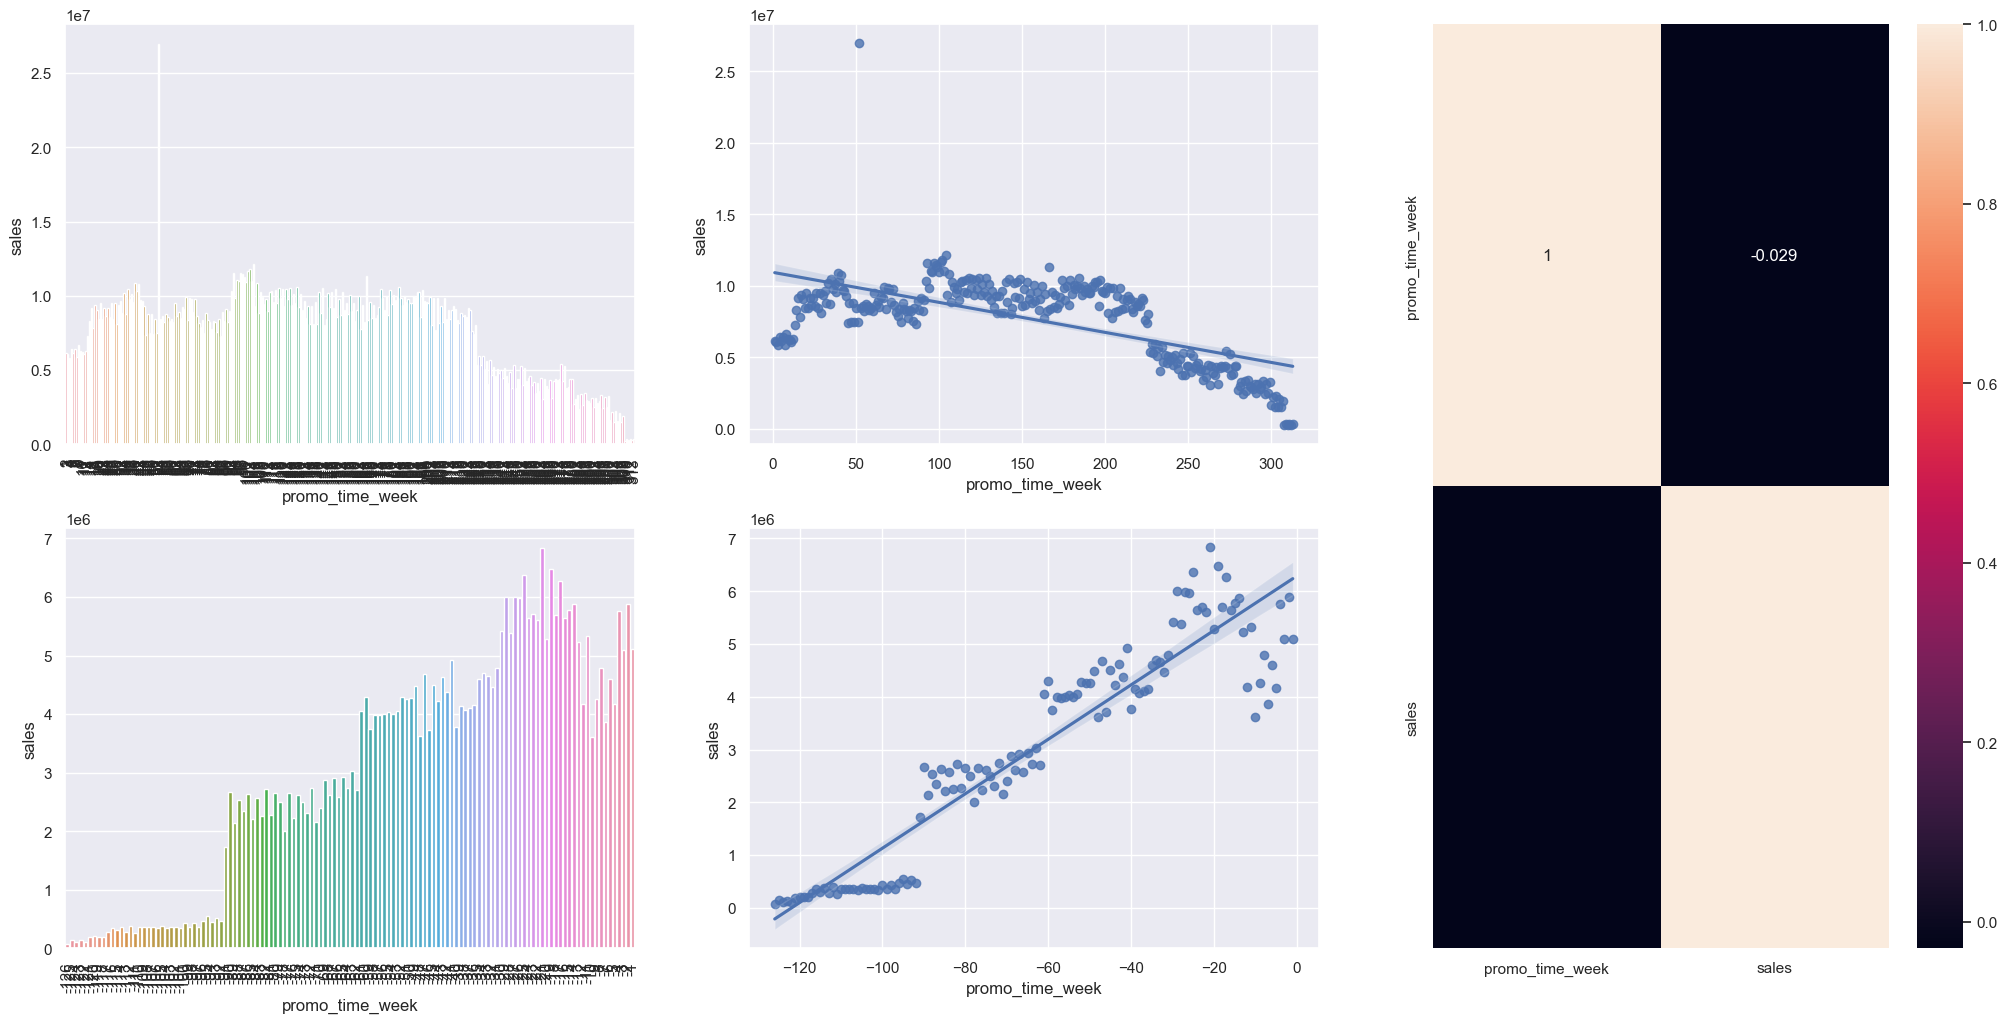

In [352]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Duas linhas e Três Colunas
grid = GridSpec(2, 3)

# Gráfico de Barras para comparar as vendas com relação ao tempo de promoção extendida
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # Promoção Extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

# Gráfico de Tendencia para verificarmos se a tendencia das vendas é crescente ou descrescente
plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


# Gráfico de Barras para comparar as vendas com relação ao tempo de promoção Regular
plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # Promoção Regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

# Gráfico de Tendencia para verificarmos se a tendencia das vendas é crescente ou descrescente
plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

# Mapa de Calor para verificarmos a correlação entre o tempo de promoção extendida e a quantiade de vendas
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

4.2.6. Lojas com mais promoções consecutivas deveriam vender mais
FALSA Lojas com mais promoções consecutivas vendem MENOS



In [353]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


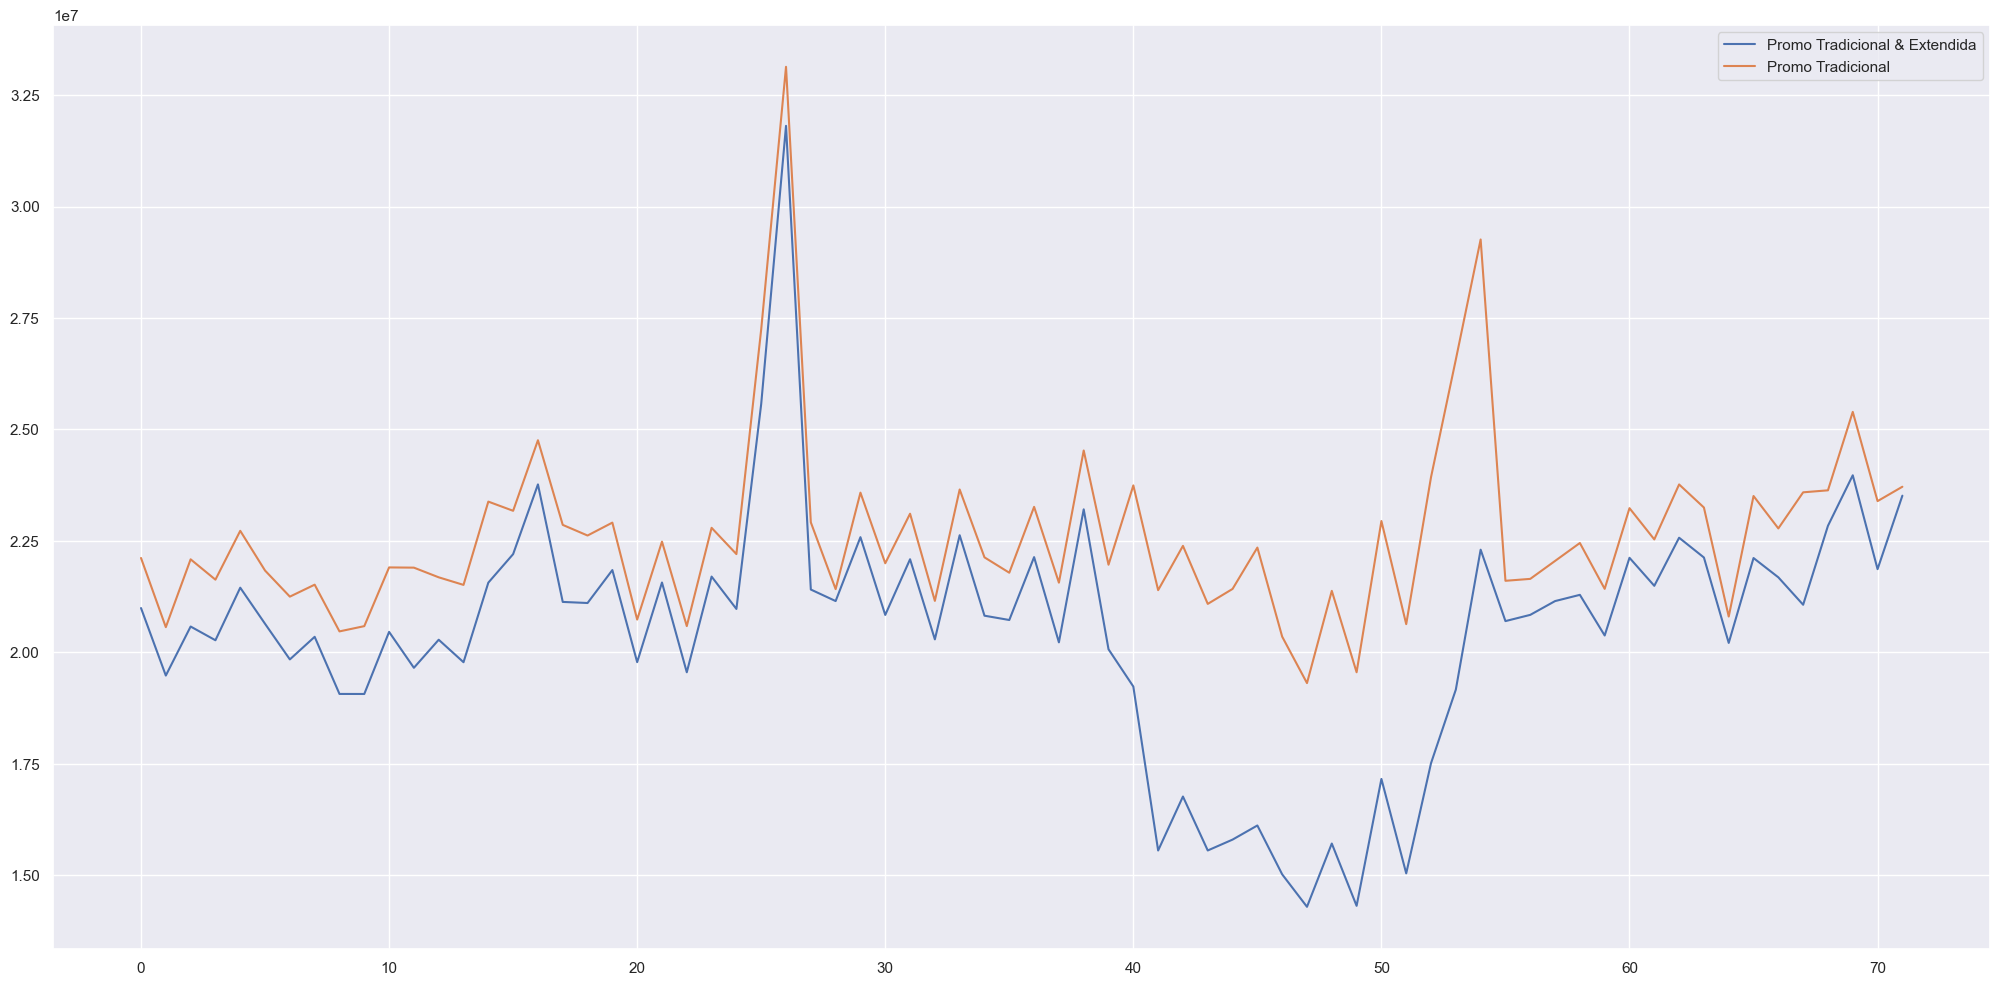

In [354]:
# Gráfico de linha para verificar o comportamento das vendas quando a loja está em promoção extendida (promo2) ao longo do tempo
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# Gráfico de linha para verificar o comportamento das vendas quando a loja está em promoção normal ao longo do tempo
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

# Adiciona as legendas
ax.legend(labels = ['Promo Tradicional & Extendida', 'Promo Tradicional']);

4.2.7. Lojas abertas durante o feriado de Natal deveriam vender mais
FALSA Lojas abertas durante o feriado de Natal Não vendem mais do que os outros feriados



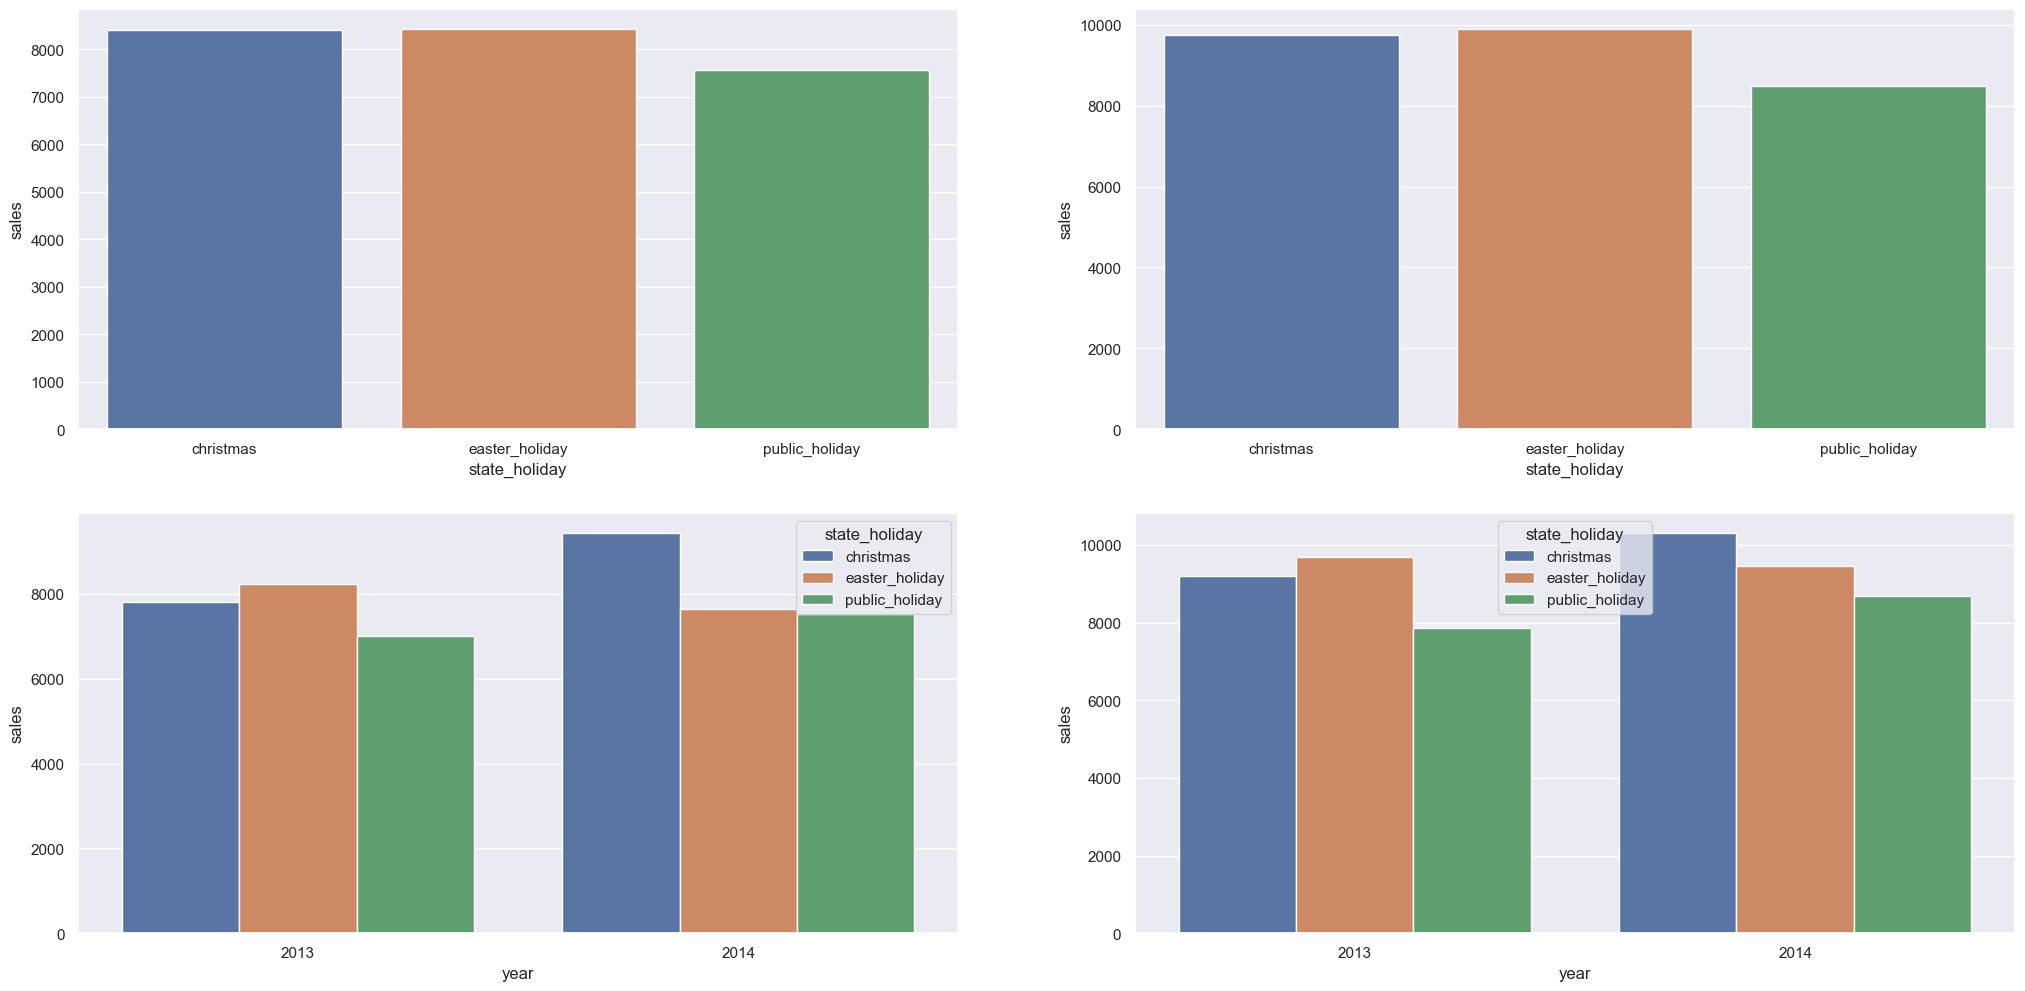

In [355]:
# Filtrando as linhas
aux = df4[df4['state_holiday'] != 'regular_day']

# Gráfico de Barras para comprar a mediana dos valores Gastos entre os tipos de feriados
plt.subplot(2, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').median().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

# Gráfico de Barras para comprar a média dos valores Gastos entre os tipos de feriados
plt.subplot(2, 2, 2)
aux2 = aux[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux2);

#Gráfico de Barras para comprar a mediana dos valores gastos ao longo dos anos entre os tipos de feriados
plt.subplot(2, 2, 3)
aux3 = aux[aux['year'] != 2015][['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).median().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux3);

#Gráfico de Barras para comprar a média dos valores gastos ao longo dos anos entre os tipos de feriados
plt.subplot(2, 2, 4)
aux4 = aux[aux['year'] != 2015][['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux4);

4.2.8. Lojas deveriam vender mais ao longo dos anos
FALSA Lojas vendem menos ao longo dos anos

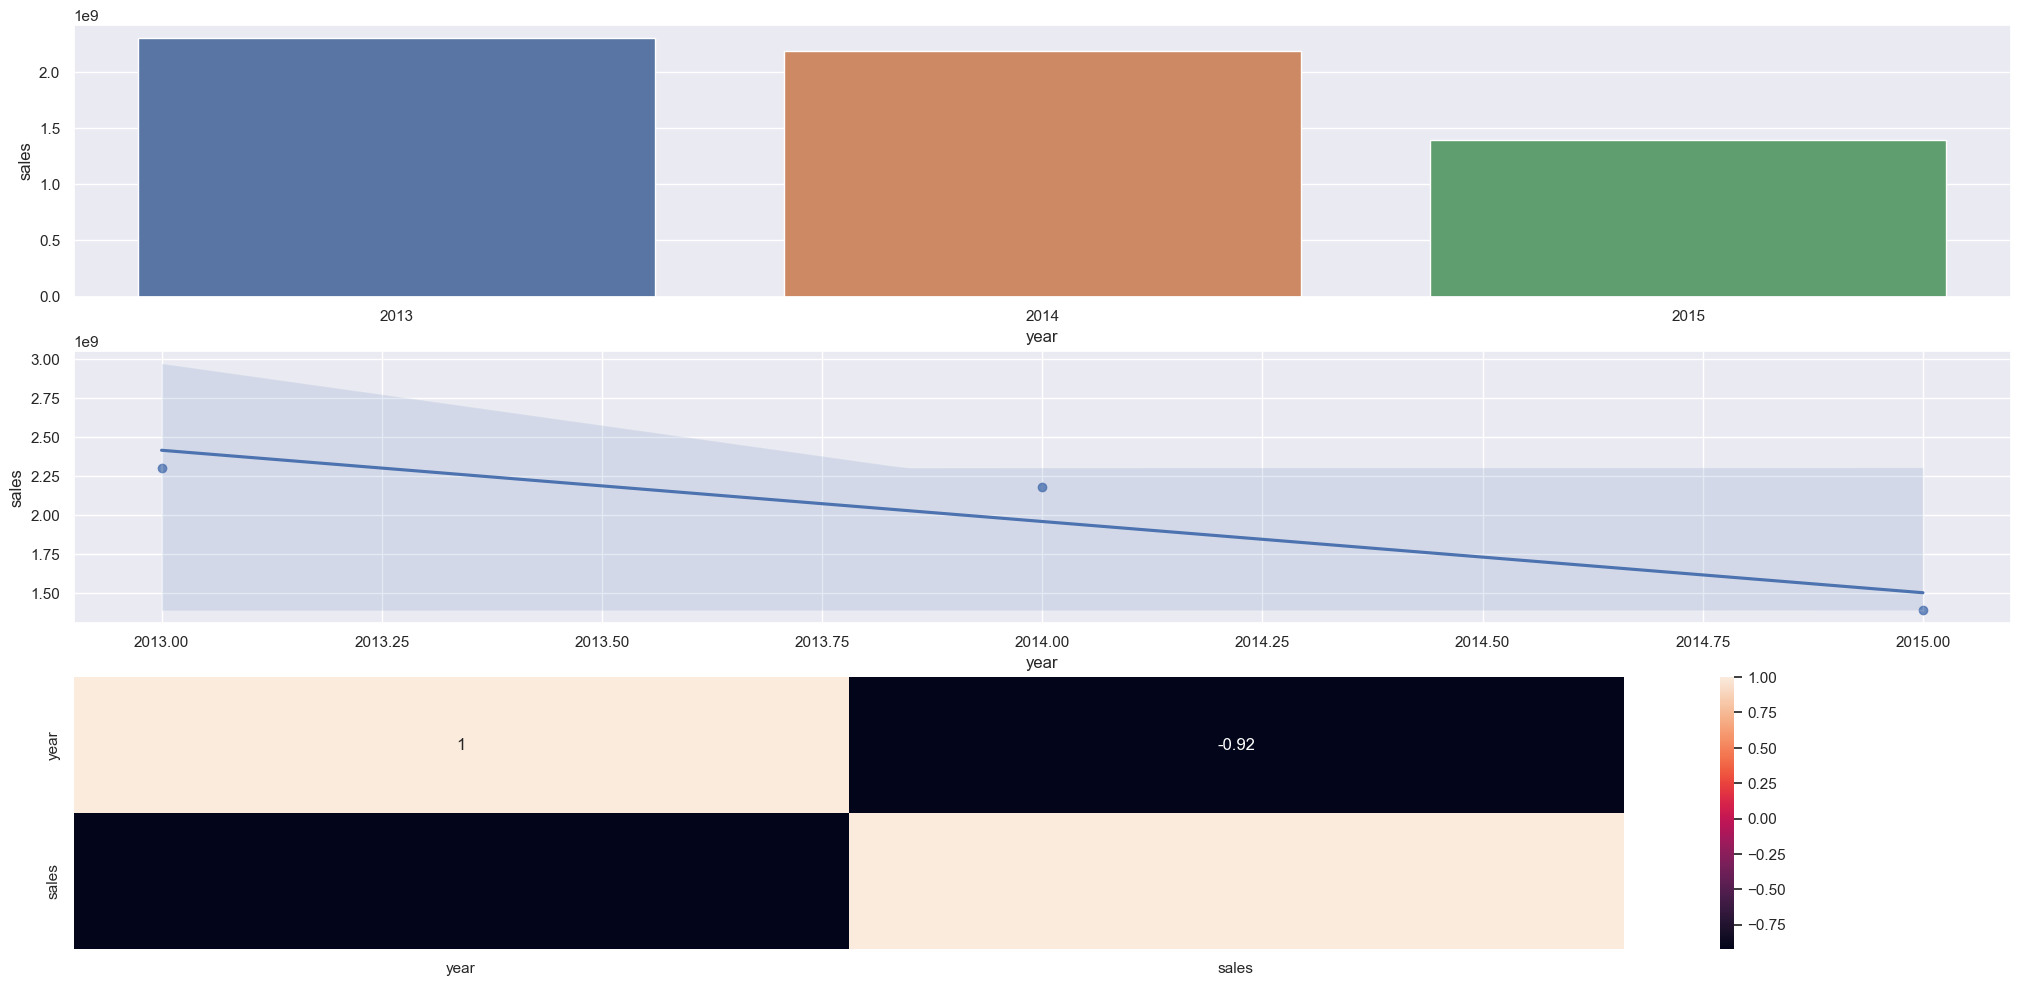

In [356]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Gráfico de Barras para comprar o valor das vendas entre os anos
plt.subplot(3, 1, 1)
sns.barplot(x='year', y='sales', data=aux1);

# Gráfico de Tendencia para verificarmos qual a tendencia das vendas ao longo dos anos
plt.subplot(3, 1, 2)
sns.regplot(x='year', y='sales', data=aux1);

# Mapa de Calor para verificarmos a correlação entre o anos e as vendas
plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

4.2.9. Lojas deveriam vender mais no segundo semestre do ano
FALSA Lojas vendem menos no segundo semestre do ano

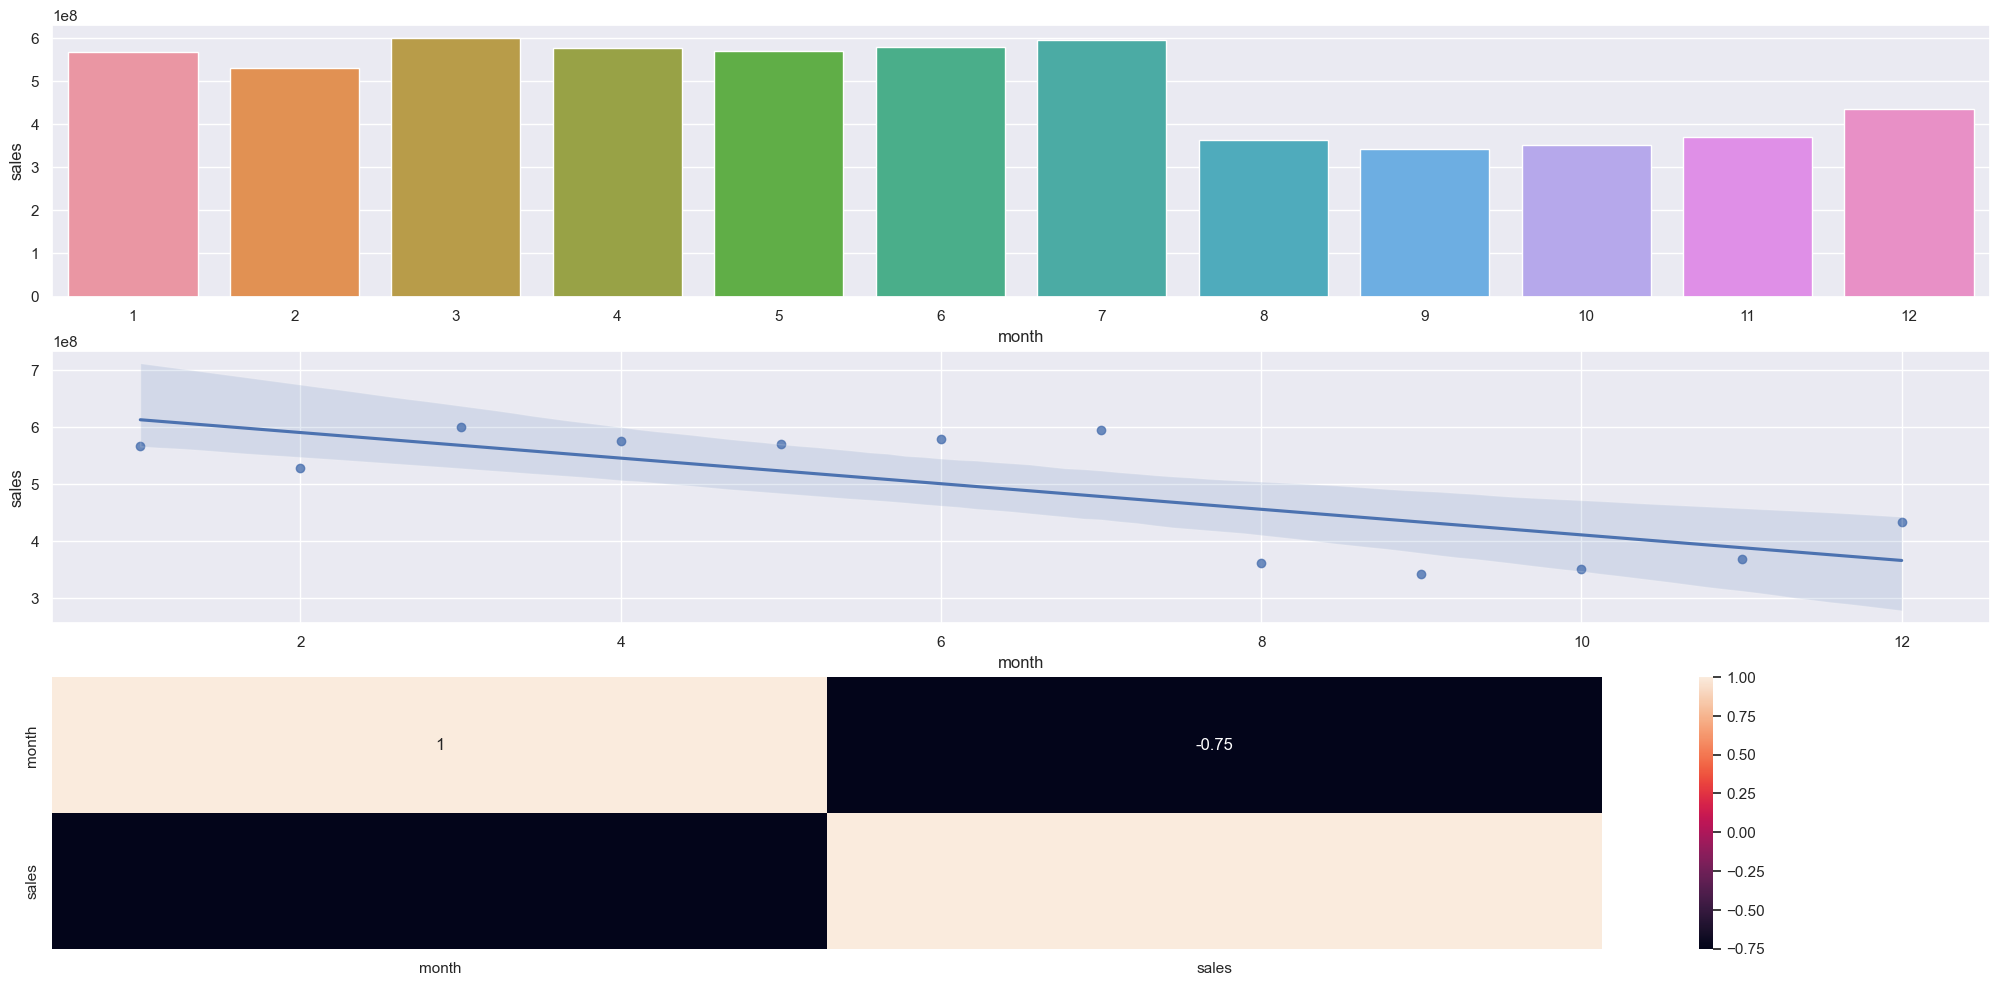

In [357]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Gráfico de Barras para comprar as vendas ao longo dos meses do ano
plt.subplot(3, 1, 1)
sns.barplot(x='month', y='sales', data=aux1);

# Gráfoico de Tendencia para verificarmos a tendencia de vendas ao longo dos meses do ano
plt.subplot(3, 1, 2)
sns.regplot(x='month', y='sales', data=aux1);

# Mapa de Calor para verificarmos a correlação entre o mês do ano e o valor de vendas
plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

4.2.10. Lojas deveriam vender mais depois do dia 10 de cada mês
VERDADEIRA Lojas Vendem MAIS depois do dia 10 de cada mês

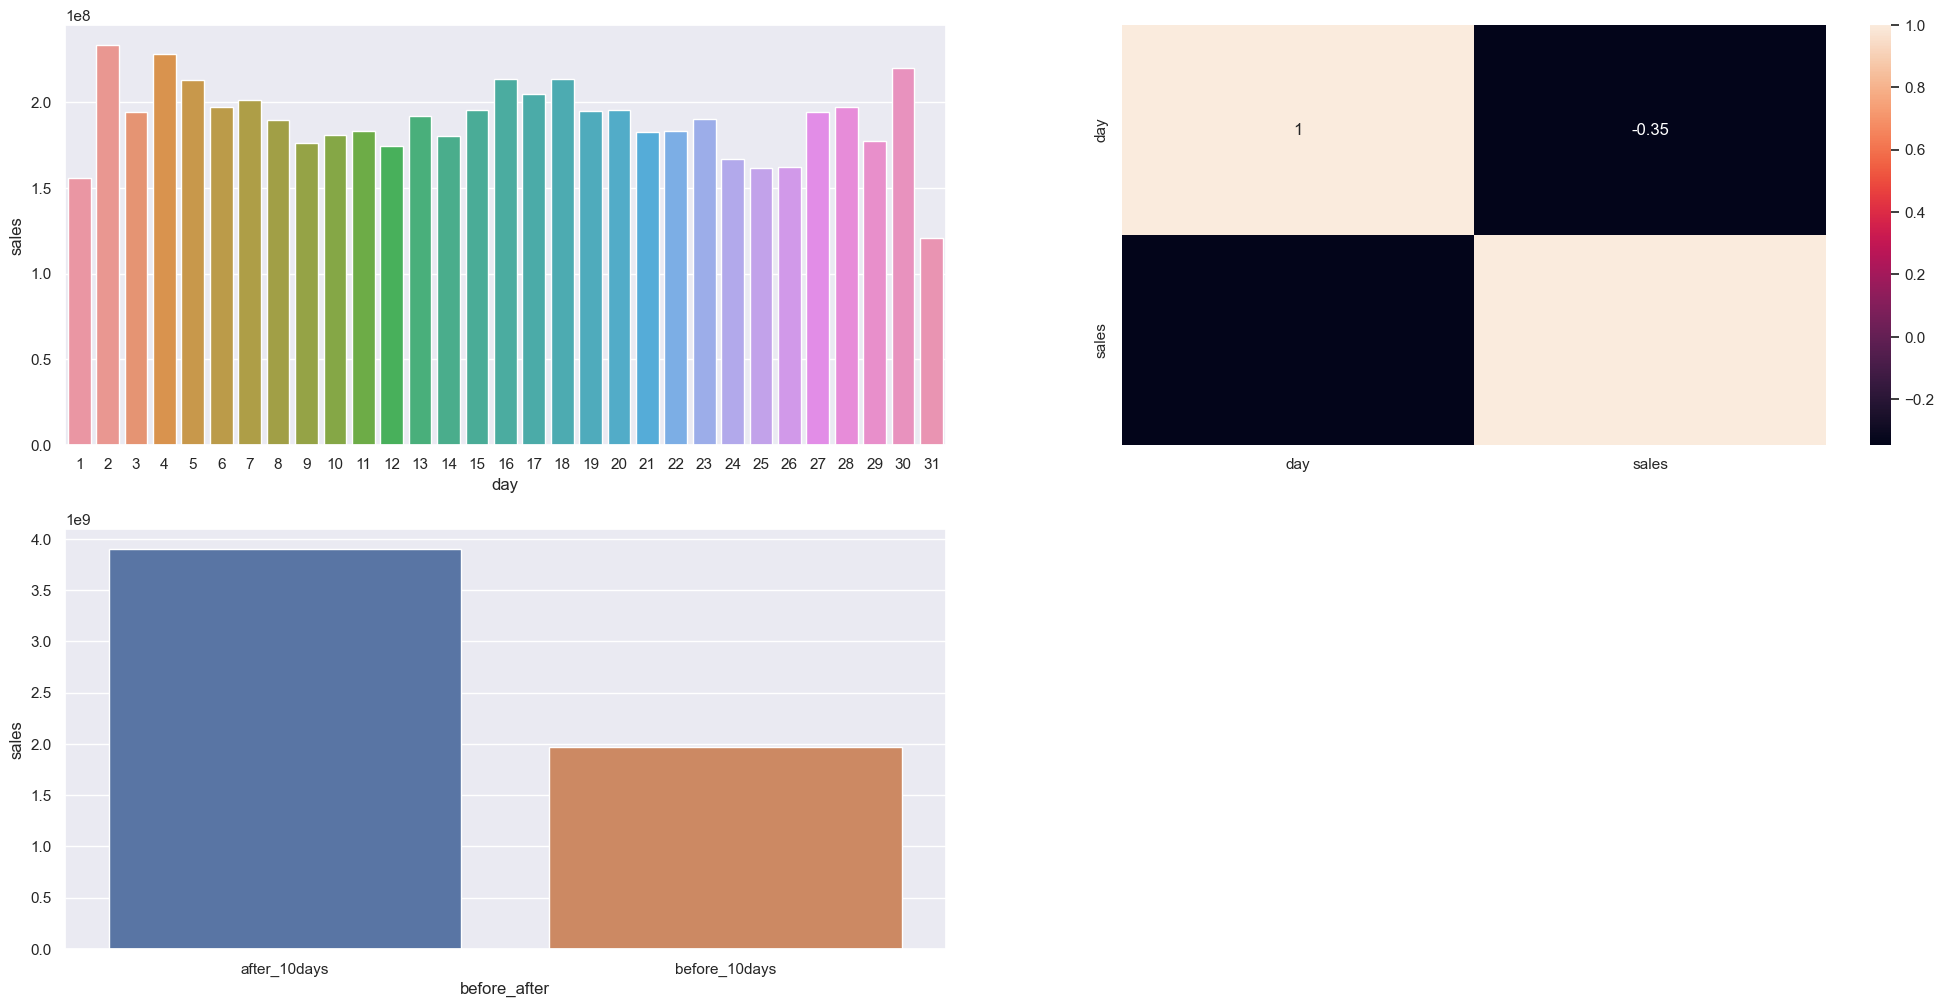

In [358]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# Gráfico de Barras para comparar as vendas ao longo dos dias do Mês
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);


# Mapa de Calor para verificarmos a correlação entre o dia do mês e o valor de vendas
plt.subplot(2, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


# Criação e filtragem de uma nova coluna para separarmos os dias antes e depois do dia 10
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10days' if x <= 10 else 'after_10days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# Gráfico de Barras para comprar as vendas antes e depois do dia 10
plt.subplot(2, 2, 3)
sns.barplot(x='before_after', y='sales', data=aux2);

4.2.11. Lojas deveriam vender menos aos finais de semana
VERDADEIRA Lojas vendem menos aos finais de semana

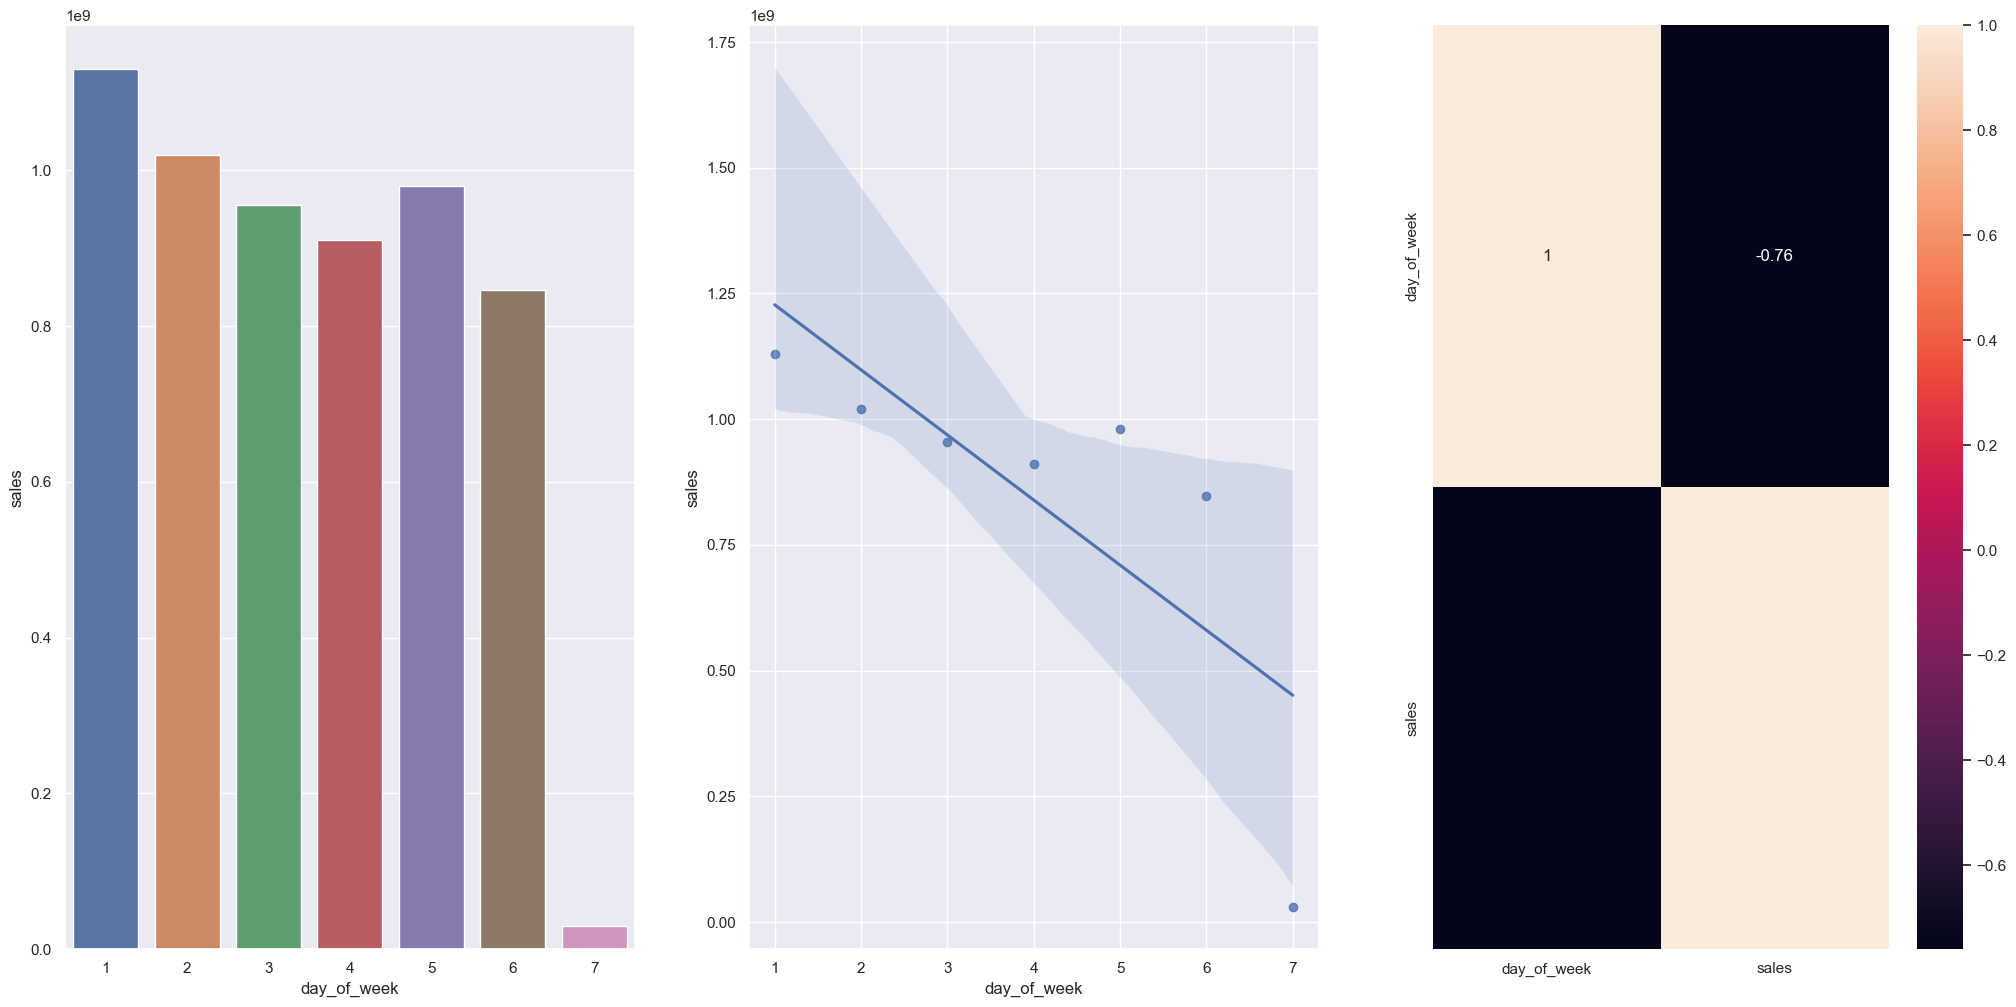

In [359]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Gráfico de Barras para verificarmos qual dia da semana vende mais
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

# Gráfico de Tendencia para verificarmos a tendencia de vendas ao longo dos dias da semana
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

# Mapa de Calor para verificarmos a correlação entre os dias da semana e o valor de vendas
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

4.2.12. Lojas deveriam vender menos durante os feriados escolares
VERDADEIRA Lojas vendem menos durante os feriados escolares, exceto em Julho e Agosto

In [360]:
df4['school_holiday'] = df4['school_holiday'].map({0:'dianormal',1:'feriado'})

<Axes: xlabel='month', ylabel='sales'>

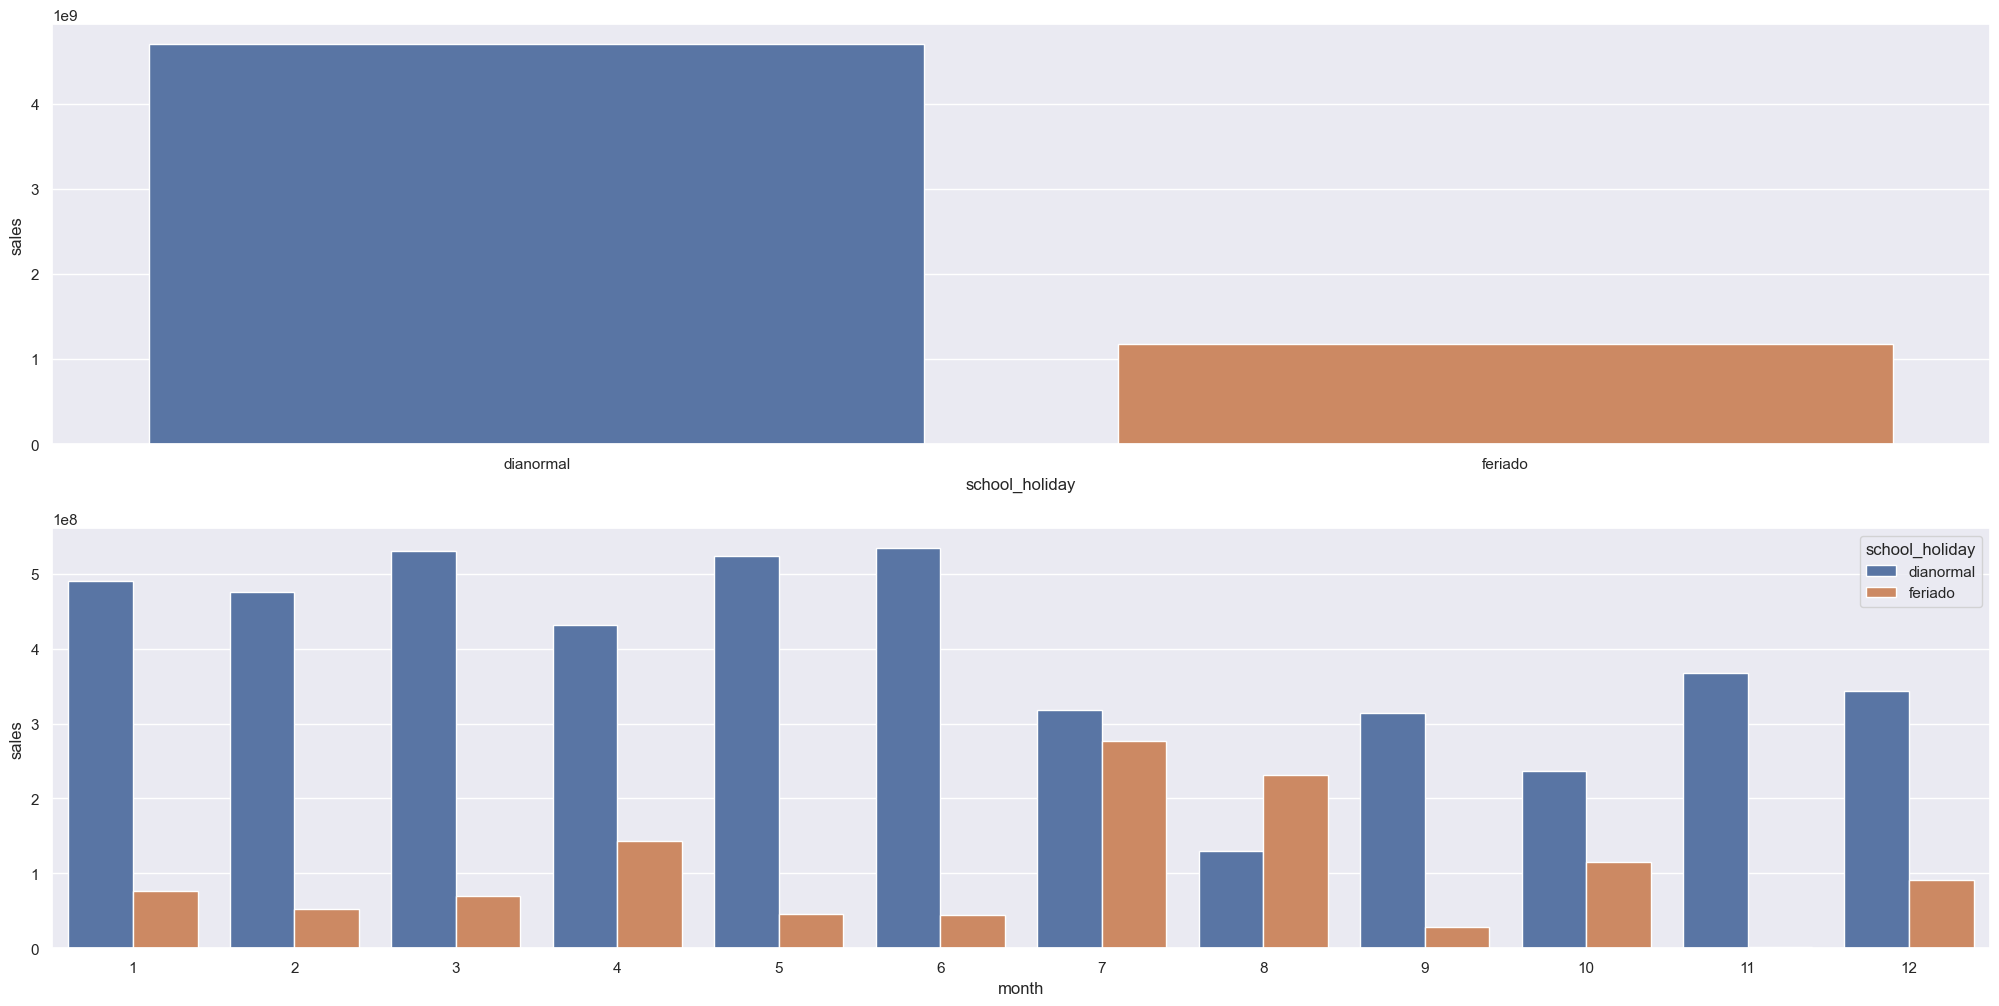

In [361]:
# Gráfico de Barras para verificarmos o valor de vendas entre os dias normais e feriados escolares
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

# Gráfico de Barras para verificarmos o valor de vendas entre os dias normais e feriados escolares ao longo do mes
plt.subplot(2, 1, 2)
aux2= df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)


4.2.13. Hypotesis Resume

In [247]:
tab = [
    ['Hypotesis', 'Conclusion', 'Relevance'],
    ['H1', 'False', 'Low'],
    ['H2', 'False', 'Medium'],
    ['H3', 'False', 'Medium'],
    ['H4', 'False', 'Low'],
    ['H5', '-', '-'],
    ['H6', 'False', 'Low'],
    ['H7', 'False', 'Medium'],
    ['H8', 'False', 'High'],
    ['H9', 'False', 'High'],
    ['H10', 'True', 'High'],
    ['H11', 'True', 'High'],
    ['H12', 'True', 'Low'],
      ]

In [251]:
print(tabulate(tab, headers='firstrow'))

Hypotesis    Conclusion    Relevance
-----------  ------------  -----------
H1           False         Low
H2           False         Medium
H3           False         Medium
H4           False         Low
H5           -             -
H6           False         Low
H7           False         Medium
H8           False         High
H9           False         High
H10          True          High
H11          True          High
H12          True          Low


4.3. Multivariate analysis #encontrar correlações entre as variaveis

4.3.1. Numerical Attributes


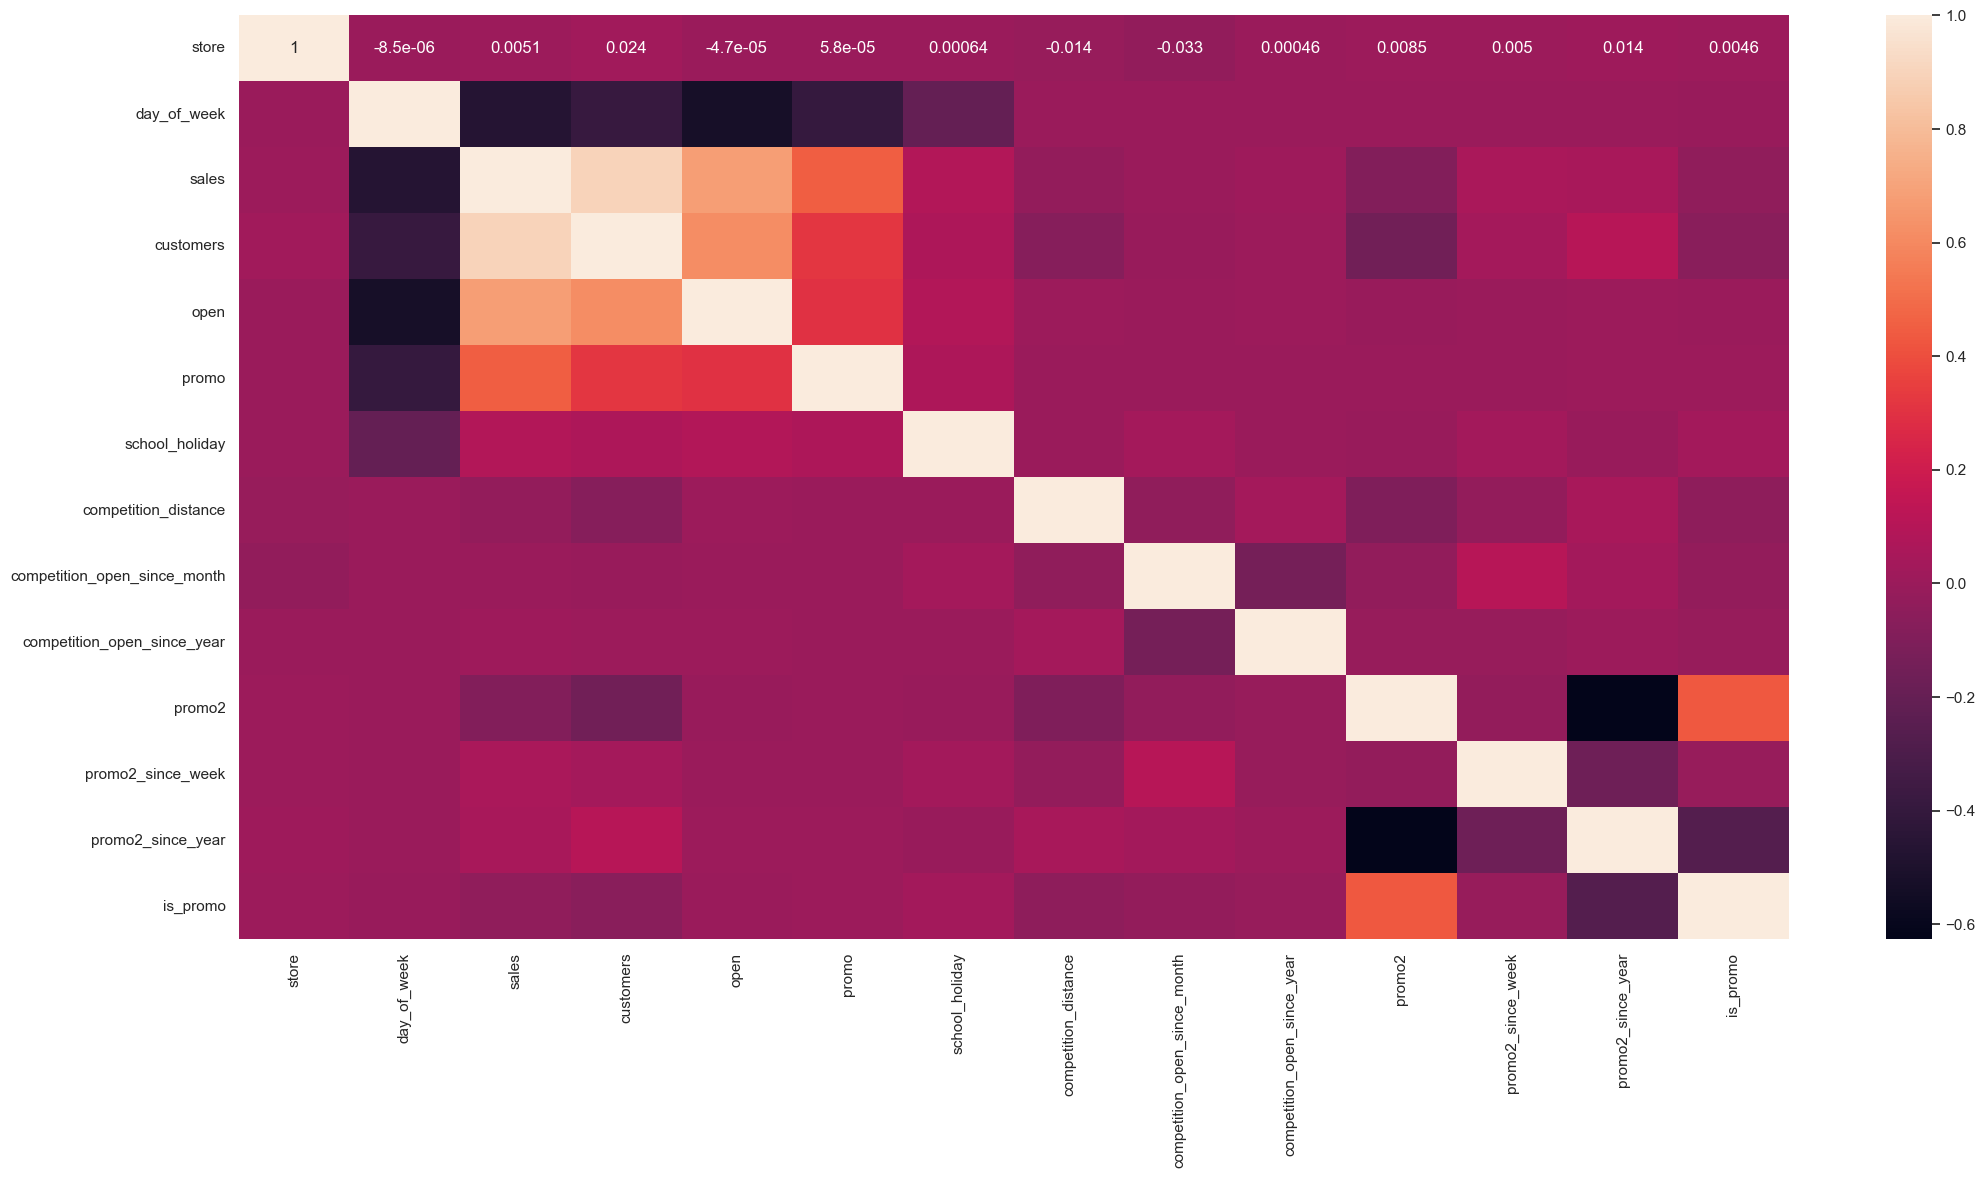

In [363]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True);

4.3.2. Categorical Attributes


<Axes: >

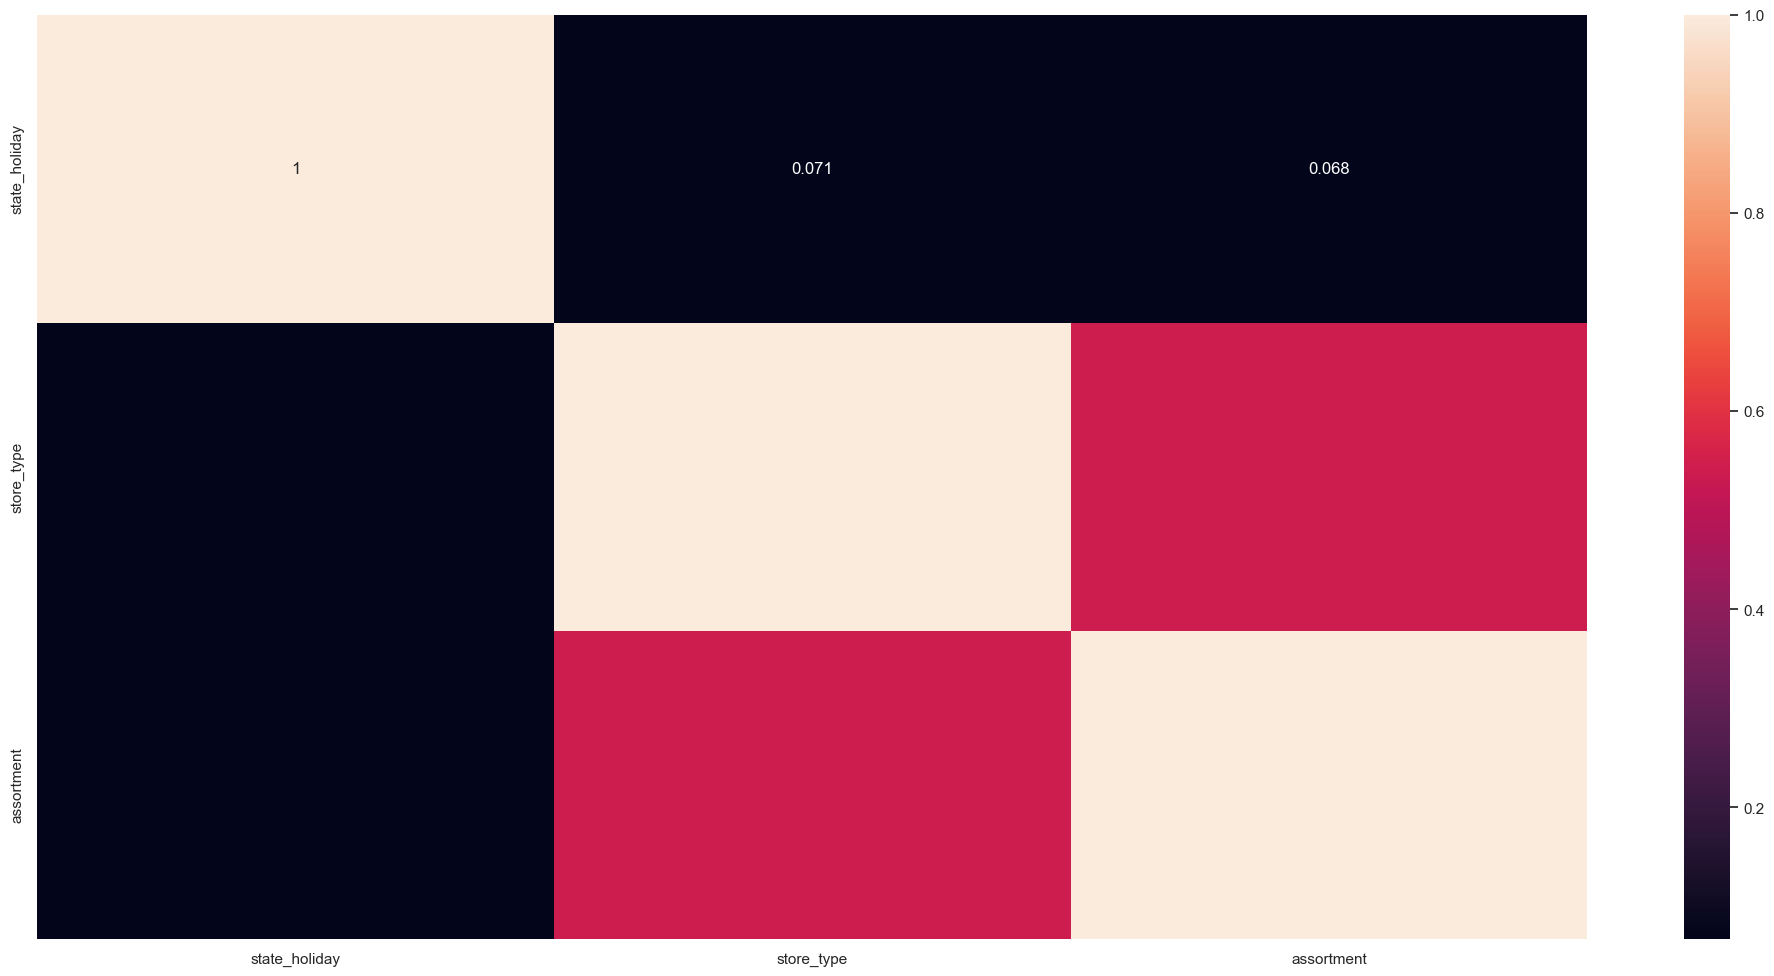

In [262]:

 # only categorical data
a = df4.select_dtypes( include='object' )
 # Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )


a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
 # Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
 'store_type': [a4, a5, a6],
 'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )